In [67]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [68]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute

from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [69]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [70]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [71]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

# file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=2.txt", 'r')
file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=2.txt")
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0


file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [72]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/150us/2024-02-06 UMD__d=2 150us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)



# paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=4/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d4):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d4.append(filenames[i])
#             break
# print (filenames_d4)





paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/150us/2024-02-06 UMD__d=8 150us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)



# paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=16/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d16 ):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d16.append(filenames[i])
#             break
# print (filenames_d16)



paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/150us/2024-02-06 UMD__d=32 150us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)



['2024-02-06-183019_Line_001.txt', '2024-02-06-183043_Line_002.txt', '2024-02-06-183106_Line_003.txt', '2024-02-06-183128_Line_004.txt', '2024-02-06-183151_Line_005.txt', '2024-02-06-183255_Line_006.txt', '2024-02-06-183317_Line_007.txt', '2024-02-06-183341_Line_008.txt', '2024-02-06-183403_Line_009.txt', '2024-02-06-183426_Line_010.txt', '2024-02-06-211039_Line_011.txt', '2024-02-06-211101_Line_012.txt', '2024-02-06-211124_Line_013.txt', '2024-02-06-211146_Line_014.txt', '2024-02-06-211208_Line_015.txt', '2024-02-06-211311_Line_016.txt', '2024-02-06-211334_Line_017.txt', '2024-02-06-211356_Line_018.txt', '2024-02-06-211419_Line_019.txt', '2024-02-06-211442_Line_020.txt']
['2024-02-06-185949_Line_001.txt', '2024-02-06-190018_Line_002.txt', '2024-02-06-190047_Line_003.txt', '2024-02-06-190116_Line_004.txt', '2024-02-06-190146_Line_005.txt', '2024-02-06-190256_Line_006.txt', '2024-02-06-190325_Line_007.txt', '2024-02-06-190354_Line_008.txt', '2024-02-06-190424_Line_009.txt', '2024-02-06-

In [73]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

# a_0703=Quantum_State(5)
# a_rerun=Quantum_State(5)

# spam1=SPAM_Operator(5)
# spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


['2024-02-06-183019_Line_001.txt', '2024-02-06-183043_Line_002.txt', '2024-02-06-183106_Line_003.txt', '2024-02-06-183128_Line_004.txt', '2024-02-06-183151_Line_005.txt', '2024-02-06-183255_Line_006.txt', '2024-02-06-183317_Line_007.txt', '2024-02-06-183341_Line_008.txt', '2024-02-06-183403_Line_009.txt', '2024-02-06-183426_Line_010.txt', '2024-02-06-211039_Line_011.txt', '2024-02-06-211101_Line_012.txt', '2024-02-06-211124_Line_013.txt', '2024-02-06-211146_Line_014.txt', '2024-02-06-211208_Line_015.txt', '2024-02-06-211311_Line_016.txt', '2024-02-06-211334_Line_017.txt', '2024-02-06-211356_Line_018.txt', '2024-02-06-211419_Line_019.txt', '2024-02-06-211442_Line_020.txt']
counts: [21, 1733, 0, 26, 25, 107, 0, 1, 0, 45, 0, 34, 0, 3, 1, 4]
counts_ibm_mapping_dic: {'0000': 21, '1000': 1733, '0100': 0, '1100': 26, '0010': 25, '1010': 107, '0110': 0, '1110': 1, '0001': 0, '1001': 45, '0101': 0, '1101': 34, '0011': 0, '1011': 3, '0111': 1, '1111': 4}


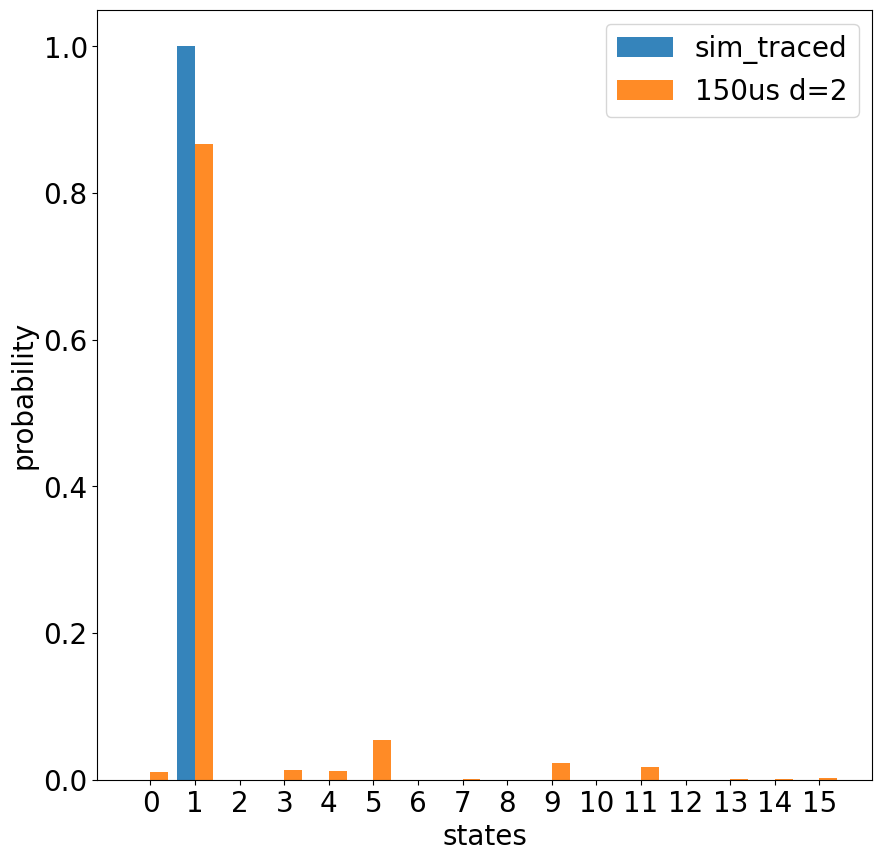

counts: [2, 17, 3, 103, 0, 2, 4, 7, 1, 41, 35, 1668, 1, 6, 34, 76]
counts_ibm_mapping_dic: {'0000': 2, '1000': 17, '0100': 3, '1100': 103, '0010': 0, '1010': 2, '0110': 4, '1110': 7, '0001': 1, '1001': 41, '0101': 35, '1101': 1668, '0011': 1, '1011': 6, '0111': 34, '1111': 76}


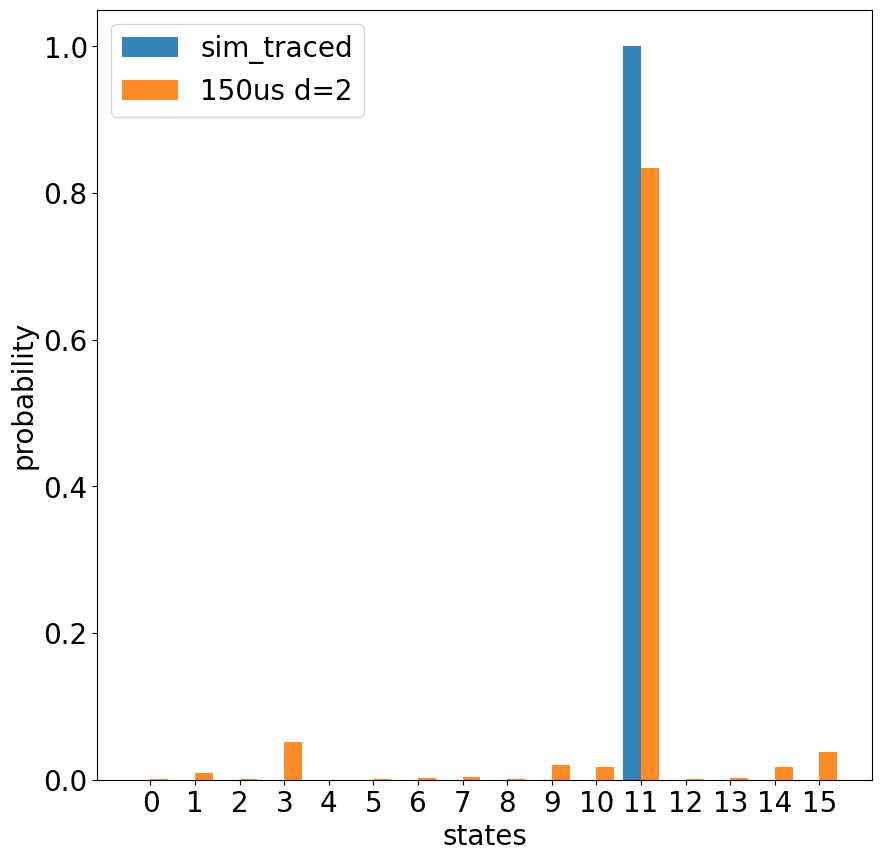

counts: [0, 5, 4, 15, 11, 61, 7, 82, 9, 4, 31, 74, 9, 41, 37, 1610]
counts_ibm_mapping_dic: {'0000': 0, '1000': 5, '0100': 4, '1100': 15, '0010': 11, '1010': 61, '0110': 7, '1110': 82, '0001': 9, '1001': 4, '0101': 31, '1101': 74, '0011': 9, '1011': 41, '0111': 37, '1111': 1610}


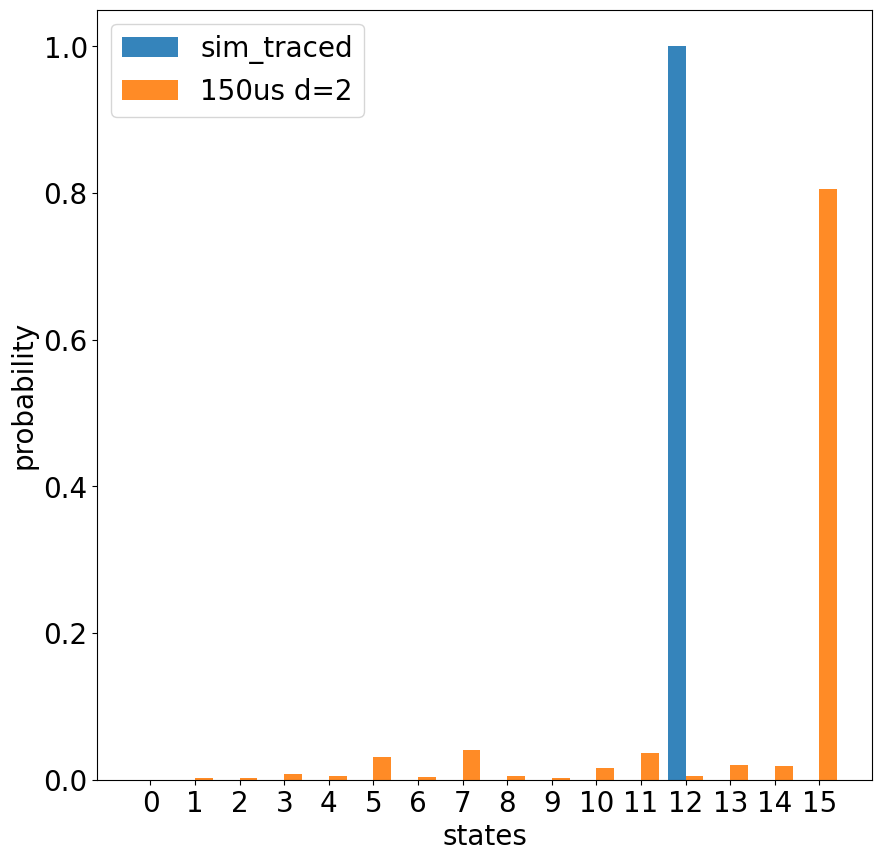

counts: [16, 2, 8, 1, 44, 0, 18, 0, 267, 22, 7, 0, 1555, 34, 22, 4]
counts_ibm_mapping_dic: {'0000': 16, '1000': 2, '0100': 8, '1100': 1, '0010': 44, '1010': 0, '0110': 18, '1110': 0, '0001': 267, '1001': 22, '0101': 7, '1101': 0, '0011': 1555, '1011': 34, '0111': 22, '1111': 4}


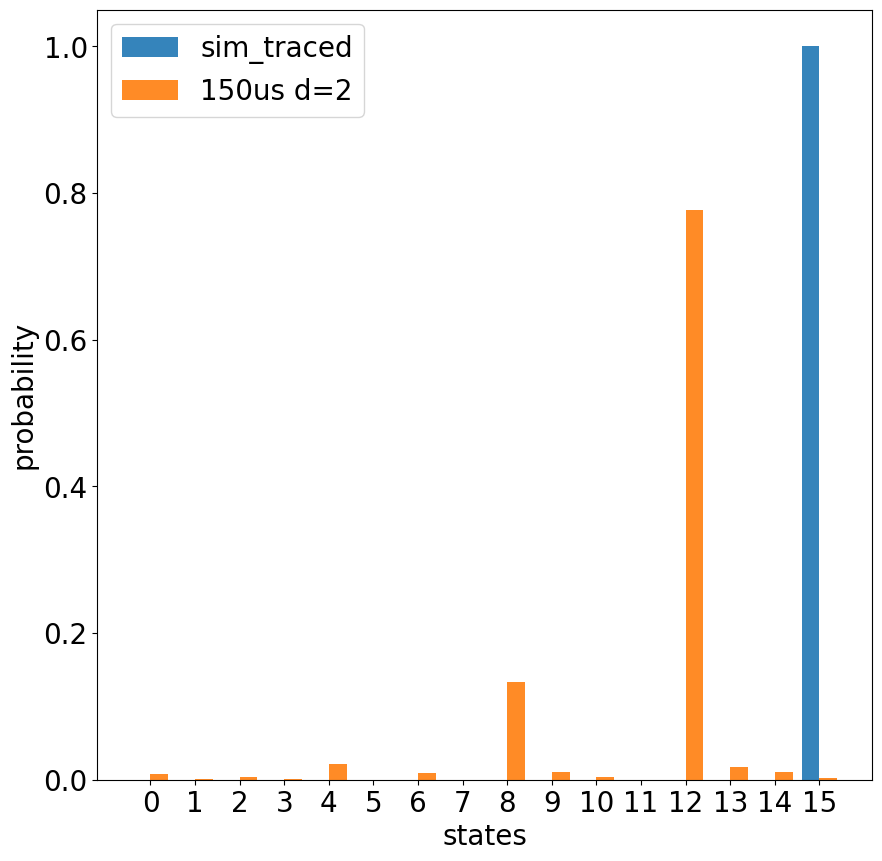

counts: [232, 31, 1, 0, 1611, 20, 17, 5, 11, 2, 5, 0, 34, 1, 29, 1]
counts_ibm_mapping_dic: {'0000': 232, '1000': 31, '0100': 1, '1100': 0, '0010': 1611, '1010': 20, '0110': 17, '1110': 5, '0001': 11, '1001': 2, '0101': 5, '1101': 0, '0011': 34, '1011': 1, '0111': 29, '1111': 1}


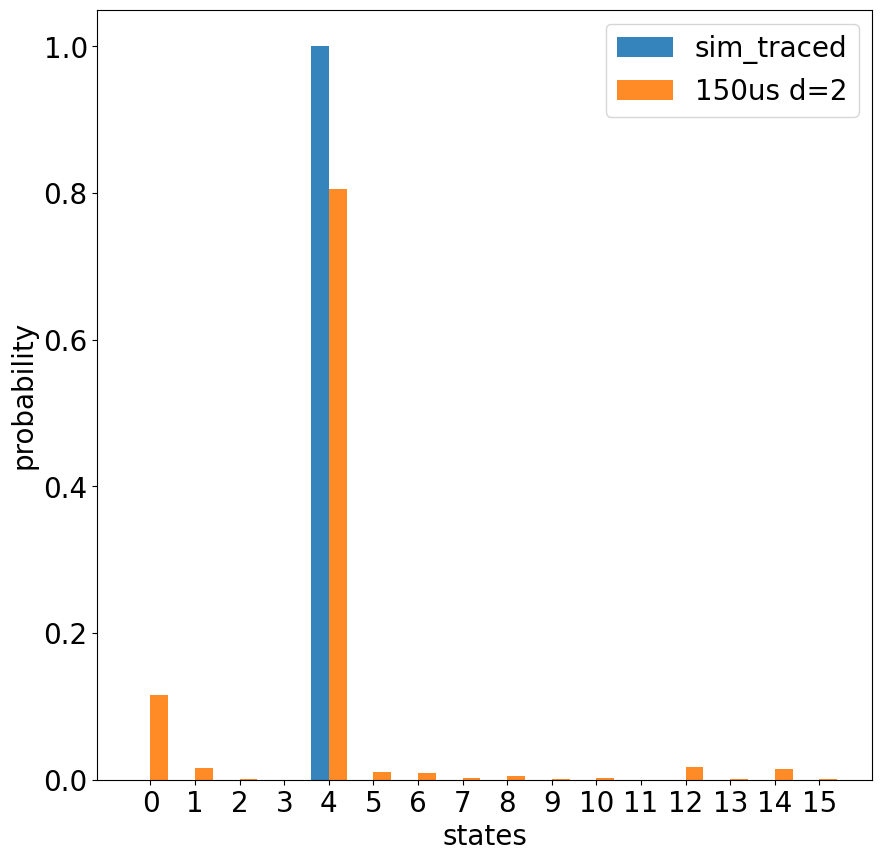

counts: [1, 2, 1, 6, 0, 31, 4, 82, 1, 3, 18, 77, 4, 63, 33, 1674]
counts_ibm_mapping_dic: {'0000': 1, '1000': 2, '0100': 1, '1100': 6, '0010': 0, '1010': 31, '0110': 4, '1110': 82, '0001': 1, '1001': 3, '0101': 18, '1101': 77, '0011': 4, '1011': 63, '0111': 33, '1111': 1674}


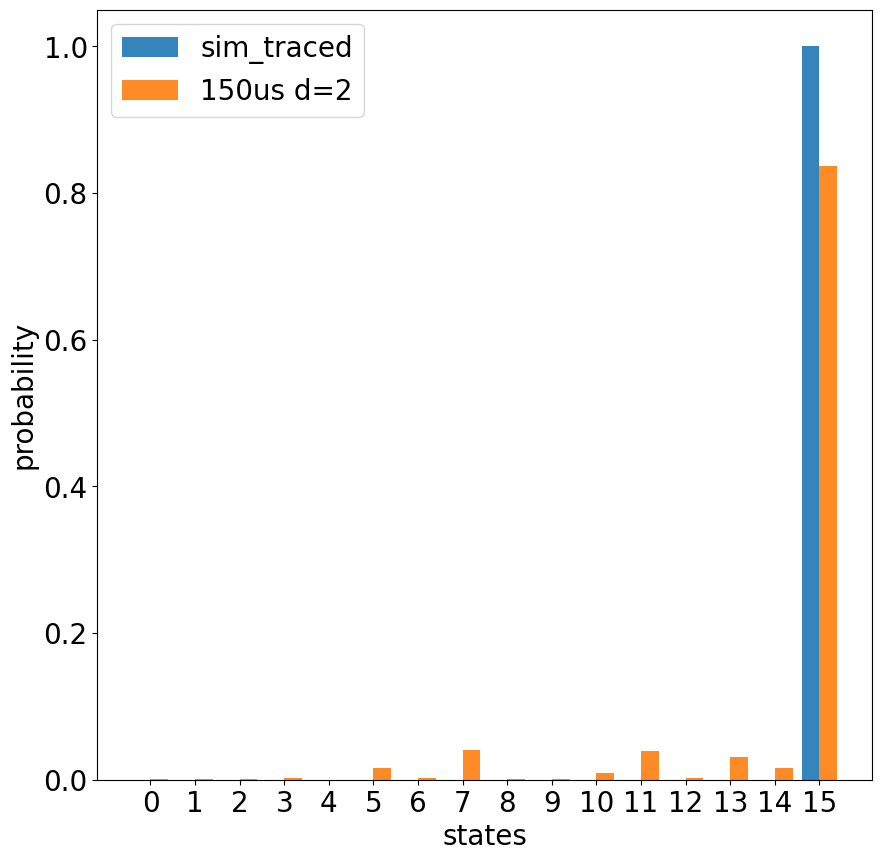

counts: [45, 1708, 1, 72, 25, 61, 1, 1, 2, 55, 0, 22, 0, 3, 1, 3]
counts_ibm_mapping_dic: {'0000': 45, '1000': 1708, '0100': 1, '1100': 72, '0010': 25, '1010': 61, '0110': 1, '1110': 1, '0001': 2, '1001': 55, '0101': 0, '1101': 22, '0011': 0, '1011': 3, '0111': 1, '1111': 3}


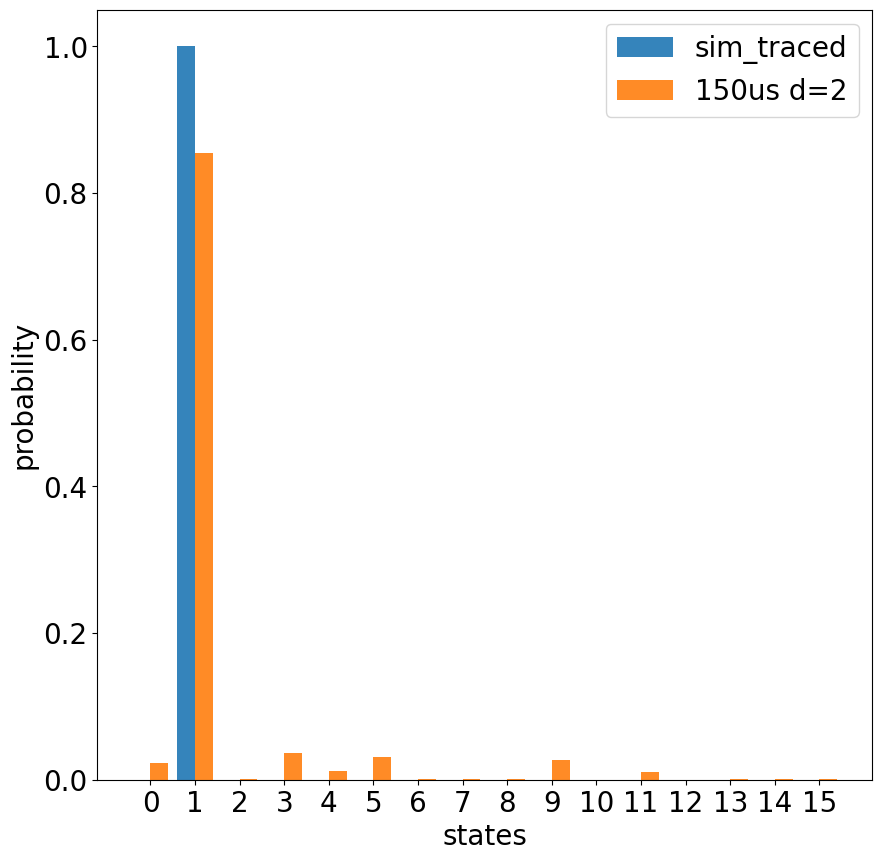

counts: [2, 29, 7, 154, 1, 5, 2, 16, 5, 36, 35, 1564, 0, 3, 15, 126]
counts_ibm_mapping_dic: {'0000': 2, '1000': 29, '0100': 7, '1100': 154, '0010': 1, '1010': 5, '0110': 2, '1110': 16, '0001': 5, '1001': 36, '0101': 35, '1101': 1564, '0011': 0, '1011': 3, '0111': 15, '1111': 126}


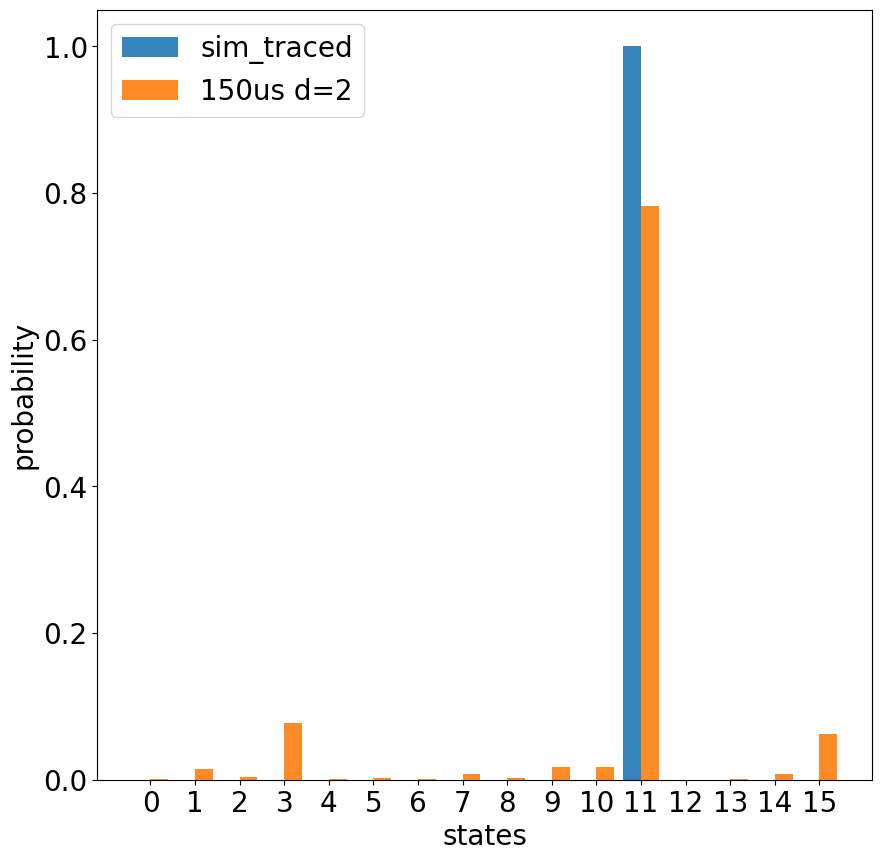

counts: [65, 1, 67, 1, 14, 0, 6, 3, 1633, 12, 27, 0, 139, 26, 5, 1]
counts_ibm_mapping_dic: {'0000': 65, '1000': 1, '0100': 67, '1100': 1, '0010': 14, '1010': 0, '0110': 6, '1110': 3, '0001': 1633, '1001': 12, '0101': 27, '1101': 0, '0011': 139, '1011': 26, '0111': 5, '1111': 1}


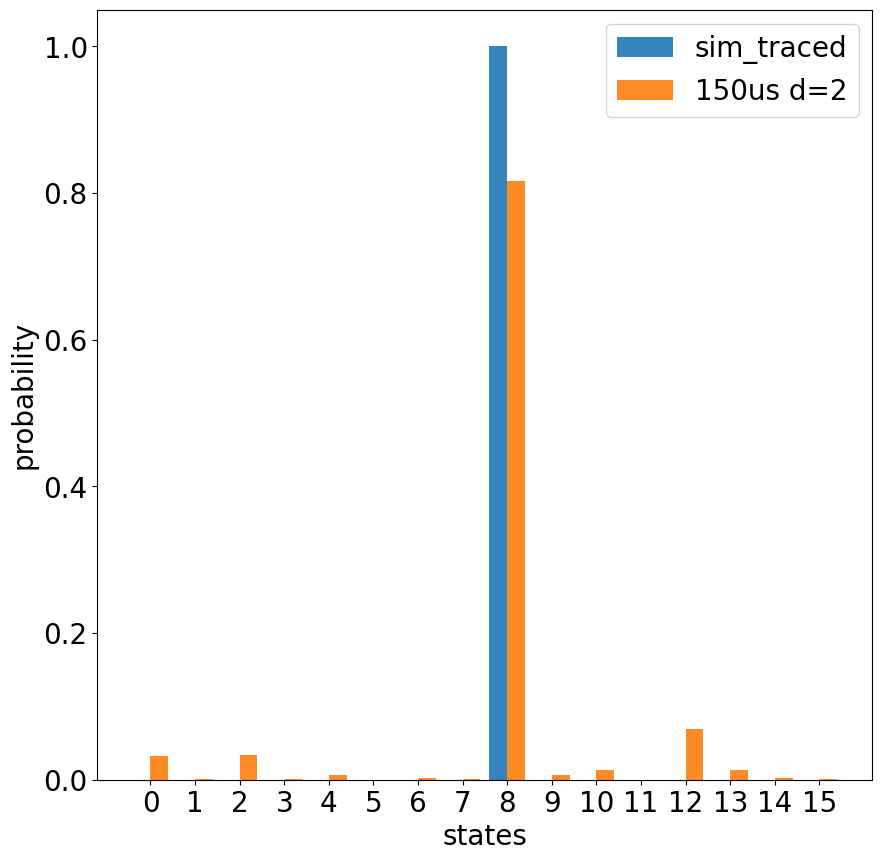

counts: [253, 24, 3, 0, 1541, 27, 16, 3, 32, 1, 3, 1, 69, 4, 22, 1]
counts_ibm_mapping_dic: {'0000': 253, '1000': 24, '0100': 3, '1100': 0, '0010': 1541, '1010': 27, '0110': 16, '1110': 3, '0001': 32, '1001': 1, '0101': 3, '1101': 1, '0011': 69, '1011': 4, '0111': 22, '1111': 1}


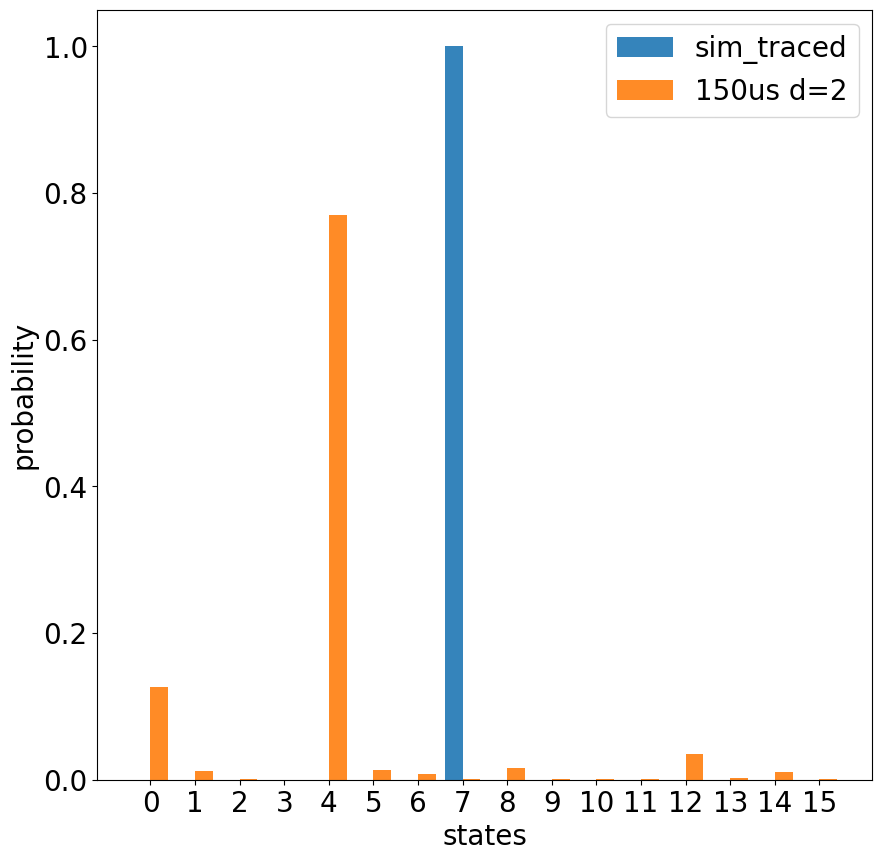

counts: [0, 5, 1, 6, 1, 31, 1, 69, 1, 0, 31, 78, 3, 32, 39, 1702]
counts_ibm_mapping_dic: {'0000': 0, '1000': 5, '0100': 1, '1100': 6, '0010': 1, '1010': 31, '0110': 1, '1110': 69, '0001': 1, '1001': 0, '0101': 31, '1101': 78, '0011': 3, '1011': 32, '0111': 39, '1111': 1702}


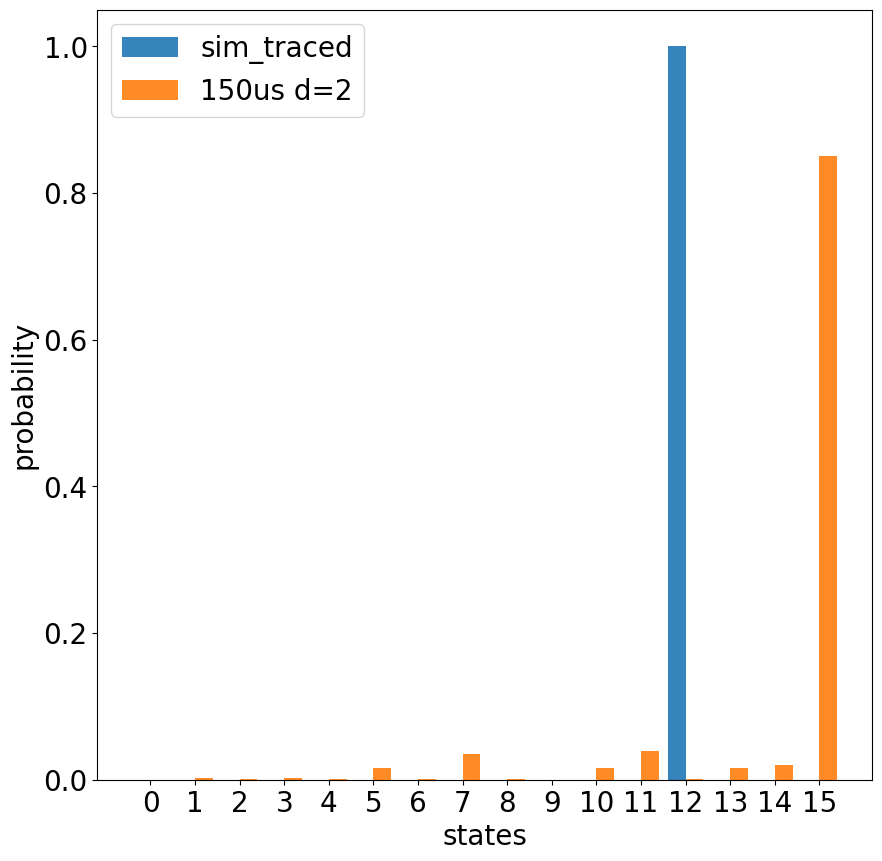

counts: [0, 34, 3, 81, 0, 0, 2, 5, 8, 60, 41, 1656, 4, 5, 29, 72]
counts_ibm_mapping_dic: {'0000': 0, '1000': 34, '0100': 3, '1100': 81, '0010': 0, '1010': 0, '0110': 2, '1110': 5, '0001': 8, '1001': 60, '0101': 41, '1101': 1656, '0011': 4, '1011': 5, '0111': 29, '1111': 72}


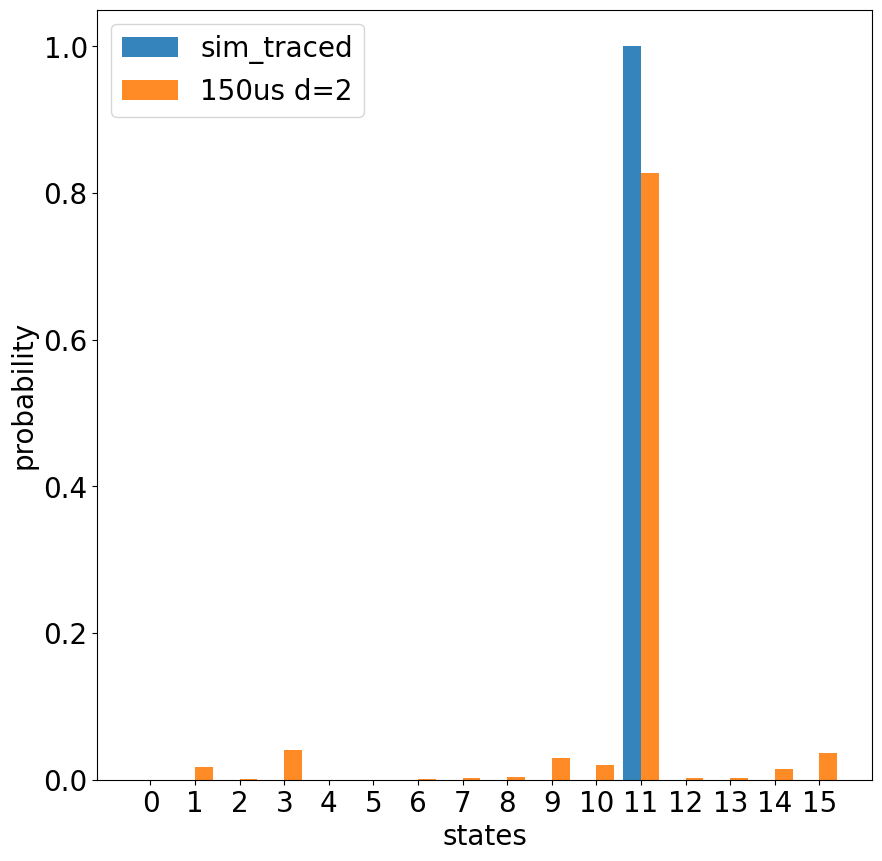

counts: [27, 78, 0, 0, 39, 1697, 4, 37, 0, 3, 0, 3, 2, 89, 3, 18]
counts_ibm_mapping_dic: {'0000': 27, '1000': 78, '0100': 0, '1100': 0, '0010': 39, '1010': 1697, '0110': 4, '1110': 37, '0001': 0, '1001': 3, '0101': 0, '1101': 3, '0011': 2, '1011': 89, '0111': 3, '1111': 18}


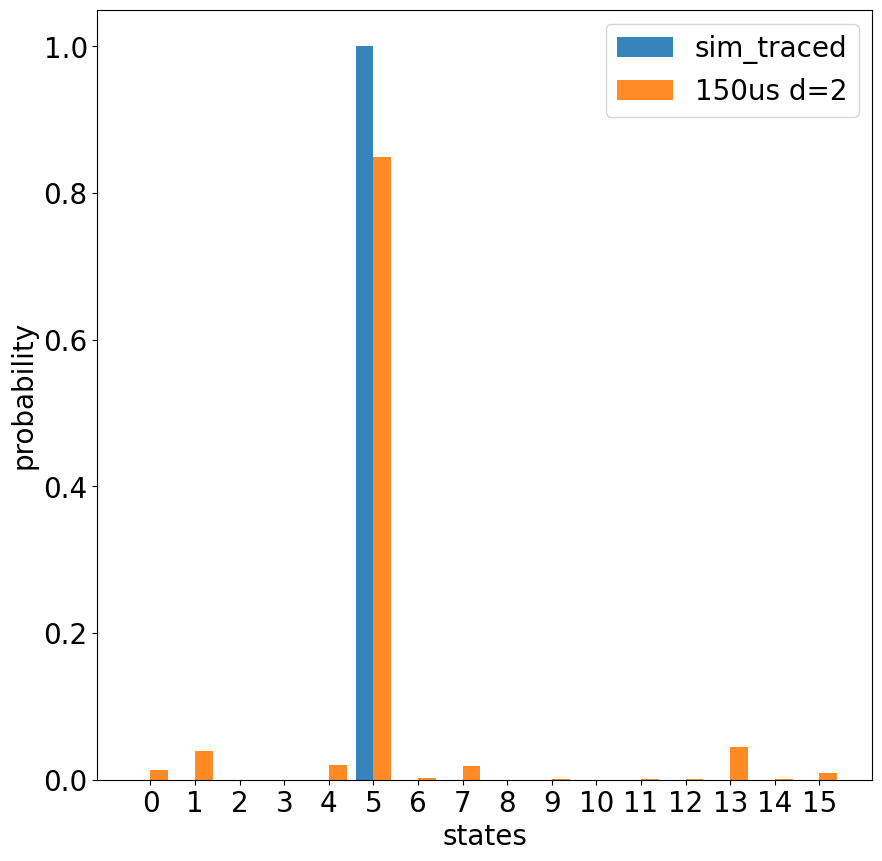

counts: [9, 0, 9, 0, 58, 1, 10, 0, 236, 29, 4, 1, 1593, 22, 24, 4]
counts_ibm_mapping_dic: {'0000': 9, '1000': 0, '0100': 9, '1100': 0, '0010': 58, '1010': 1, '0110': 10, '1110': 0, '0001': 236, '1001': 29, '0101': 4, '1101': 1, '0011': 1593, '1011': 22, '0111': 24, '1111': 4}


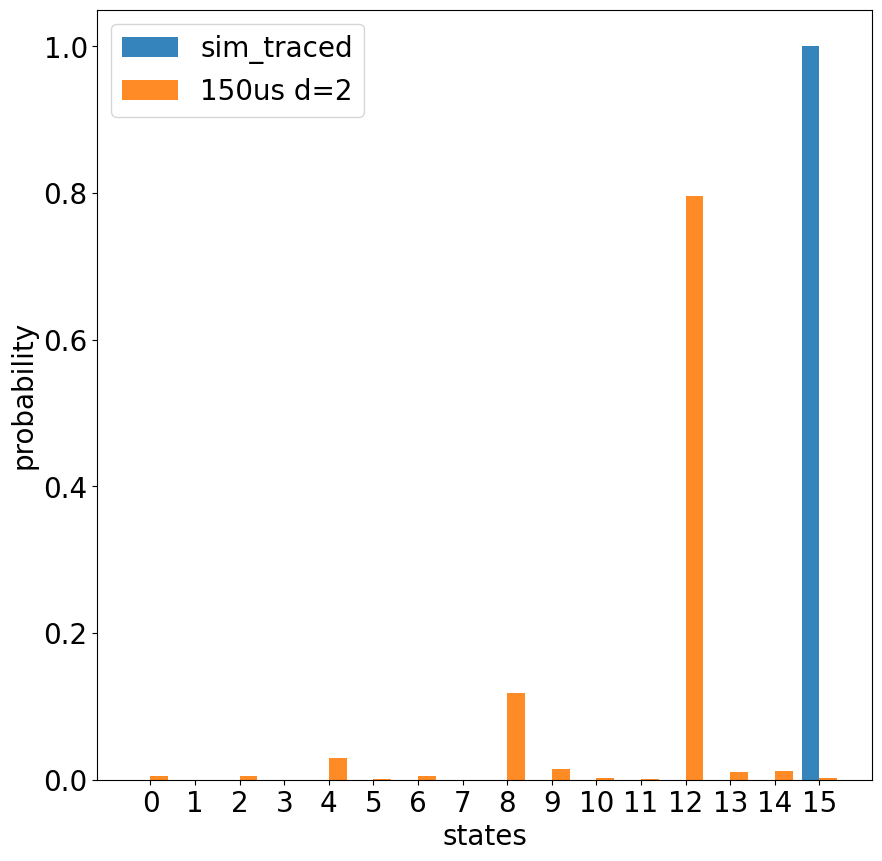

counts: [16, 33, 40, 1634, 11, 8, 24, 37, 5, 49, 10, 109, 6, 4, 5, 9]
counts_ibm_mapping_dic: {'0000': 16, '1000': 33, '0100': 40, '1100': 1634, '0010': 11, '1010': 8, '0110': 24, '1110': 37, '0001': 5, '1001': 49, '0101': 10, '1101': 109, '0011': 6, '1011': 4, '0111': 5, '1111': 9}


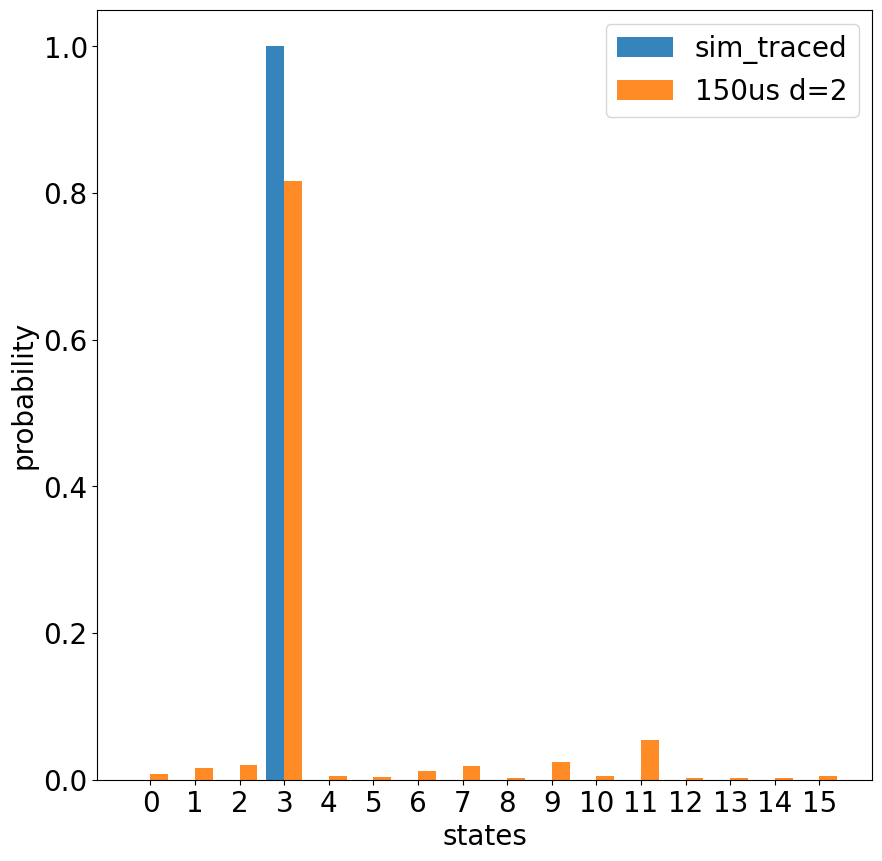

counts: [7, 0, 241, 27, 40, 2, 1539, 36, 3, 1, 9, 0, 43, 3, 47, 2]
counts_ibm_mapping_dic: {'0000': 7, '1000': 0, '0100': 241, '1100': 27, '0010': 40, '1010': 2, '0110': 1539, '1110': 36, '0001': 3, '1001': 1, '0101': 9, '1101': 0, '0011': 43, '1011': 3, '0111': 47, '1111': 2}


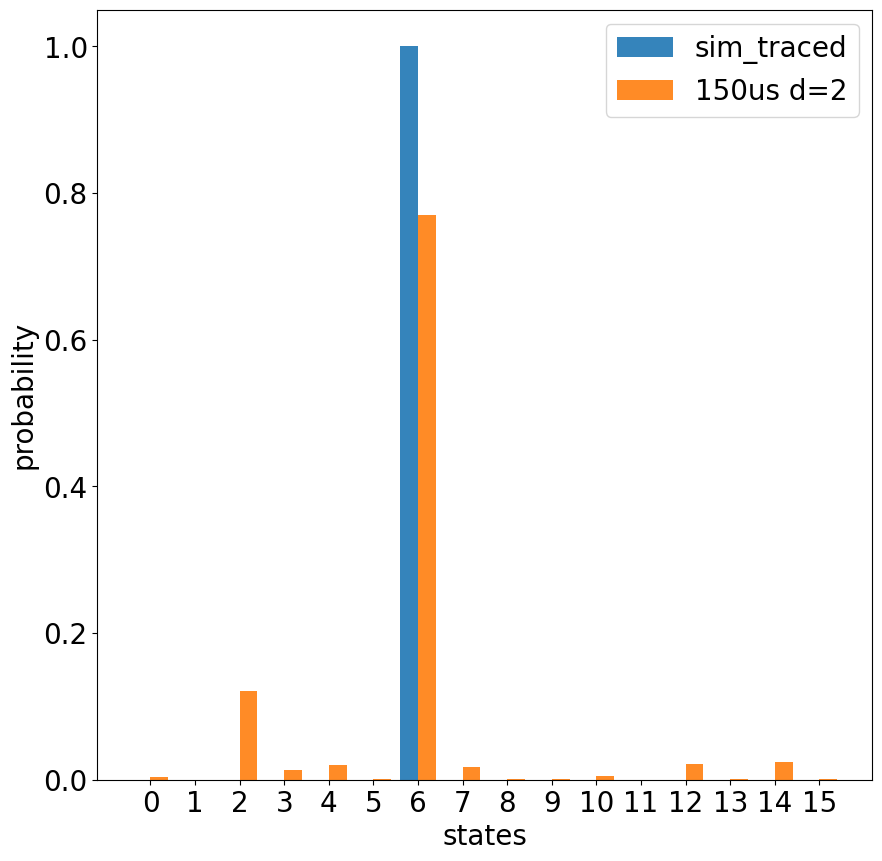

counts: [1614, 19, 18, 3, 232, 27, 2, 2, 39, 1, 16, 1, 21, 0, 5, 0]
counts_ibm_mapping_dic: {'0000': 1614, '1000': 19, '0100': 18, '1100': 3, '0010': 232, '1010': 27, '0110': 2, '1110': 2, '0001': 39, '1001': 1, '0101': 16, '1101': 1, '0011': 21, '1011': 0, '0111': 5, '1111': 0}


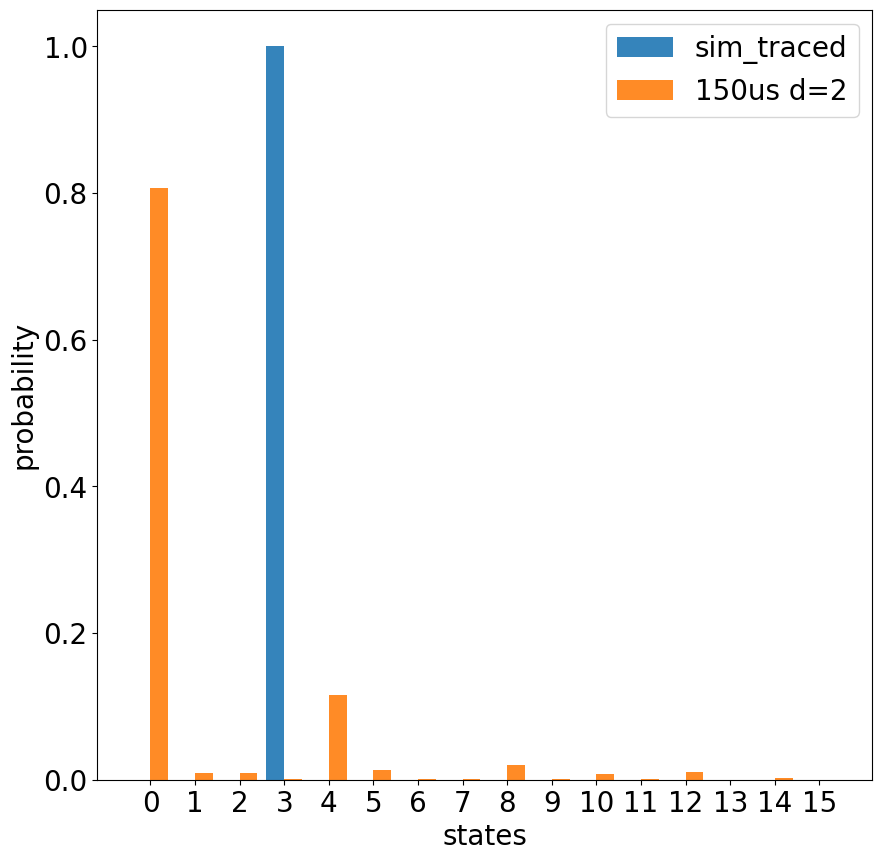

counts: [70, 1, 73, 0, 10, 3, 9, 1, 1600, 17, 12, 5, 171, 26, 1, 1]
counts_ibm_mapping_dic: {'0000': 70, '1000': 1, '0100': 73, '1100': 0, '0010': 10, '1010': 3, '0110': 9, '1110': 1, '0001': 1600, '1001': 17, '0101': 12, '1101': 5, '0011': 171, '1011': 26, '0111': 1, '1111': 1}


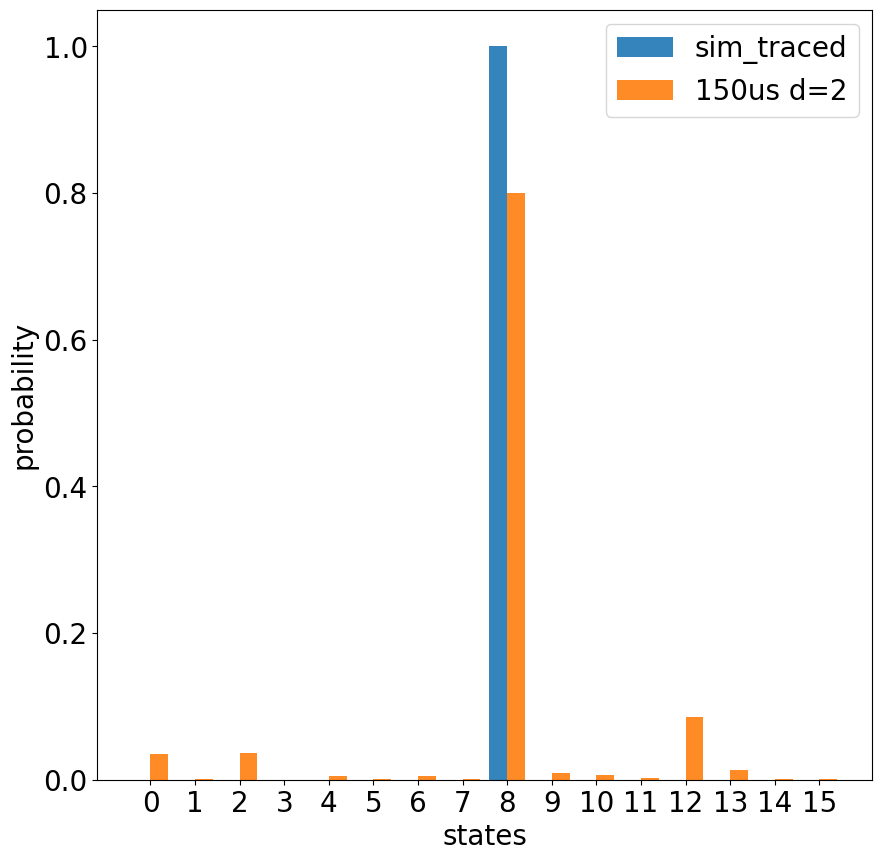

counts: [8, 0, 14, 1, 51, 1, 63, 0, 5, 3, 229, 24, 37, 3, 1527, 34]
counts_ibm_mapping_dic: {'0000': 8, '1000': 0, '0100': 14, '1100': 1, '0010': 51, '1010': 1, '0110': 63, '1110': 0, '0001': 5, '1001': 3, '0101': 229, '1101': 24, '0011': 37, '1011': 3, '0111': 1527, '1111': 34}


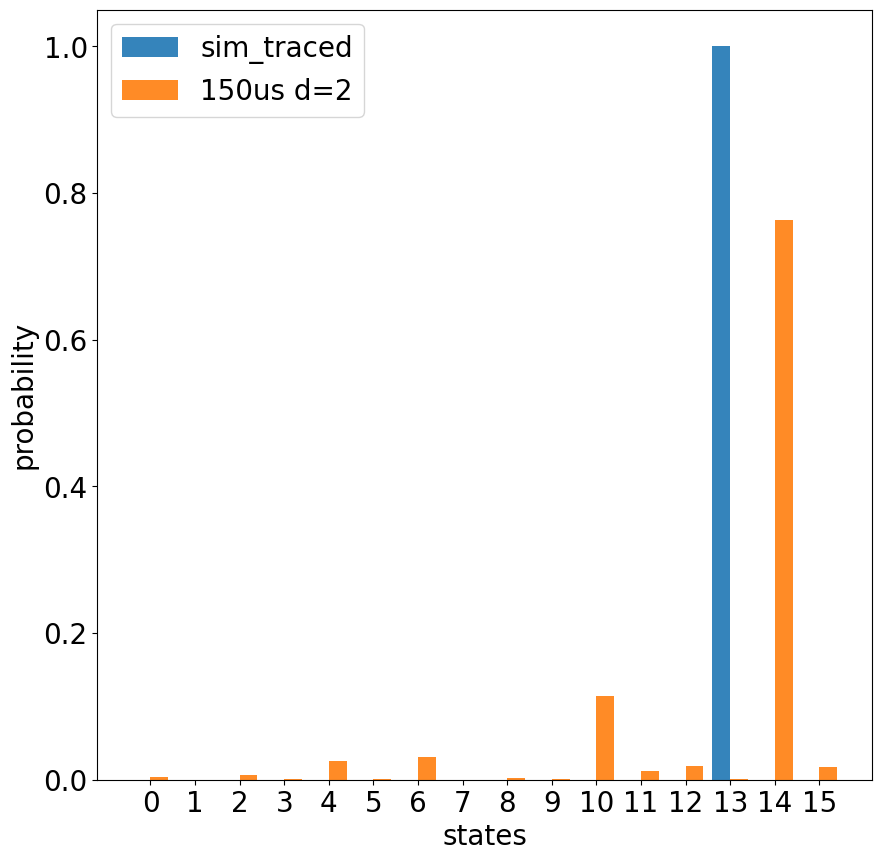

counts: [40, 1752, 3, 49, 23, 48, 1, 0, 2, 52, 0, 23, 0, 6, 0, 1]
counts_ibm_mapping_dic: {'0000': 40, '1000': 1752, '0100': 3, '1100': 49, '0010': 23, '1010': 48, '0110': 1, '1110': 0, '0001': 2, '1001': 52, '0101': 0, '1101': 23, '0011': 0, '1011': 6, '0111': 0, '1111': 1}


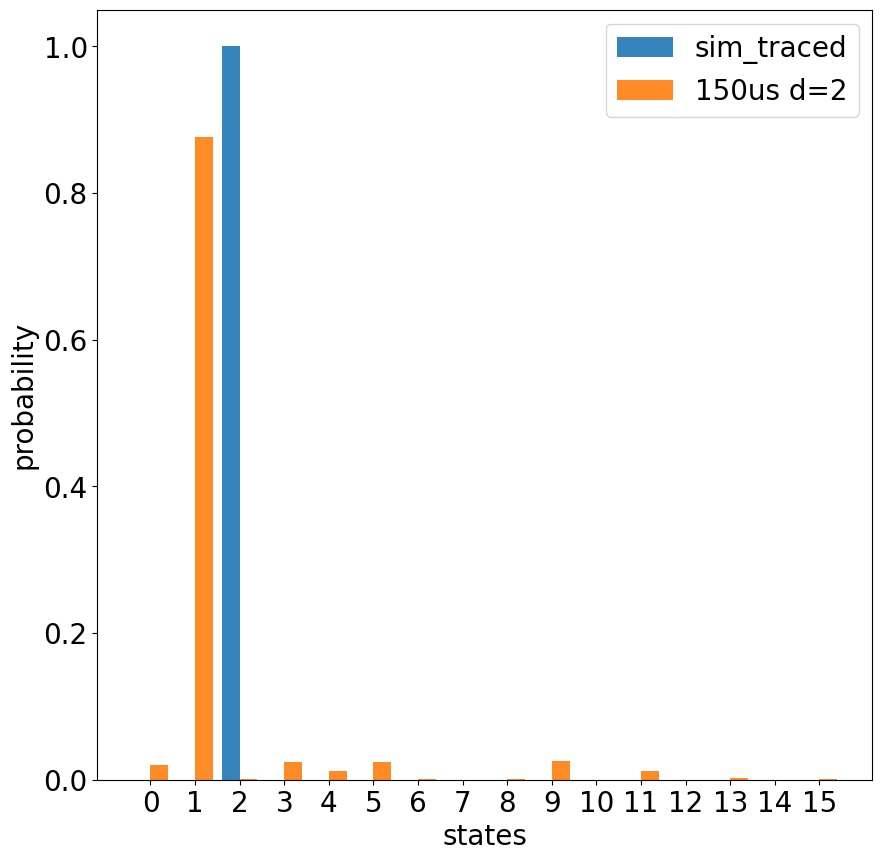

In [74]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]

filenames_data=filenames_d2.copy()
print (filenames_data)
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s=a
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)


    
    b_c.Interpret_GatesLab_Sequence(c_d2[i])
    # print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    # counts_sim=[round(shots*x) for x in sim_traced.population]
    # counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    # counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a,a_0703],label=["simulation","d=2 0711","0115 identity channel"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","150us d=2"])
# #       


In [75]:
# filenames_data=[]
# counts_d4=[]
# counts_d4_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d4_0703.copy()
# print (filenames_data)
# paf_data=paf_data_d4_0703
# circuit=c_d4
# for i in range (len(filenames_data)):
# #     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d4.append(counts_ibm_mapping_dic)
    
    
# #     a_s=spam1.Correct_SPAM(a)
# #     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
# #     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
# #     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
# #     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
# #     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
# #     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
#     Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# # #         

['2024-02-06-185949_Line_001.txt', '2024-02-06-190018_Line_002.txt', '2024-02-06-190047_Line_003.txt', '2024-02-06-190116_Line_004.txt', '2024-02-06-190146_Line_005.txt', '2024-02-06-190256_Line_006.txt', '2024-02-06-190325_Line_007.txt', '2024-02-06-190354_Line_008.txt', '2024-02-06-190424_Line_009.txt', '2024-02-06-190454_Line_010.txt', '2024-02-06-204350_Line_011.txt', '2024-02-06-204419_Line_012.txt', '2024-02-06-204448_Line_013.txt', '2024-02-06-204517_Line_014.txt', '2024-02-06-204546_Line_015.txt', '2024-02-06-204656_Line_016.txt', '2024-02-06-204725_Line_017.txt', '2024-02-06-204754_Line_018.txt', '2024-02-06-204823_Line_019.txt', '2024-02-06-204852_Line_020.txt']
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:AZ

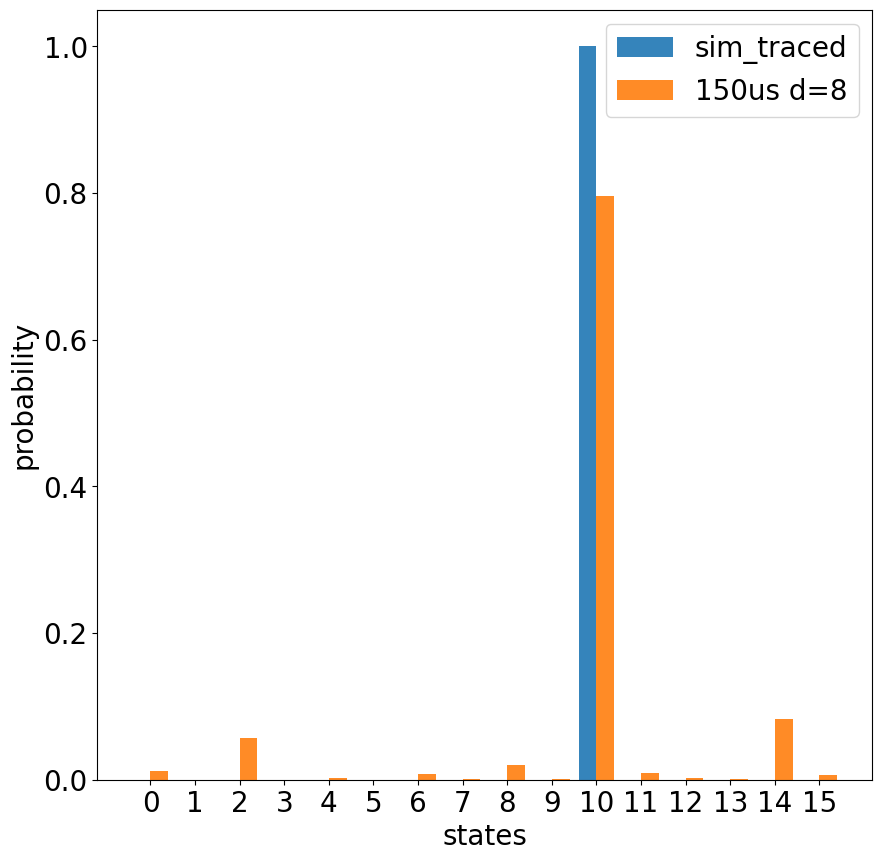

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



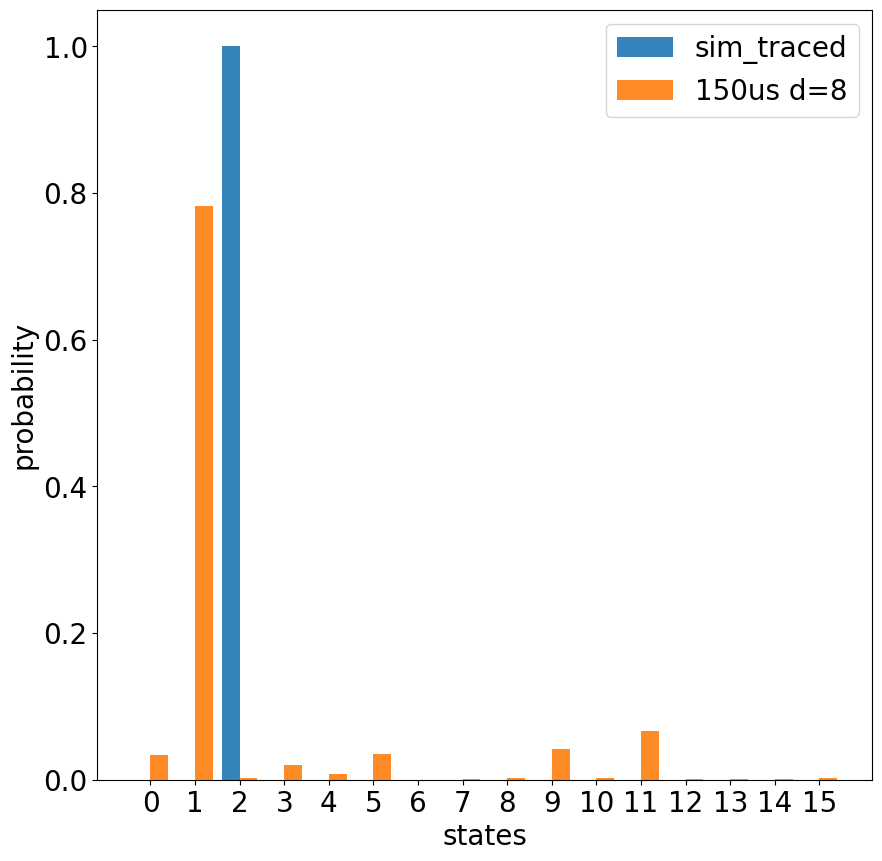

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



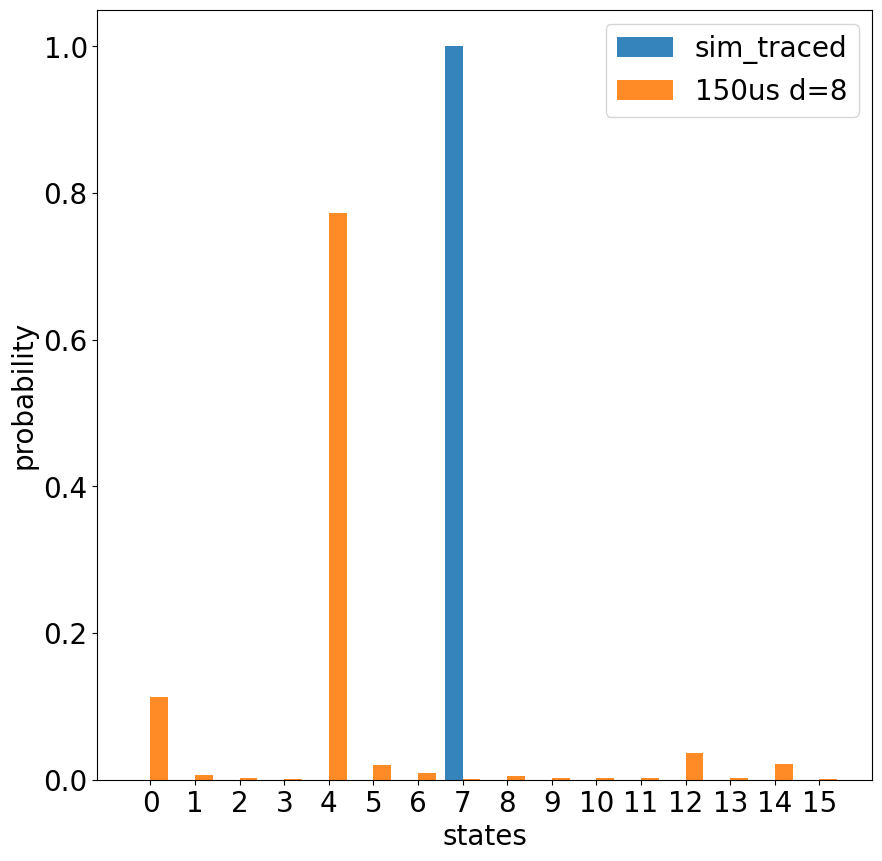

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



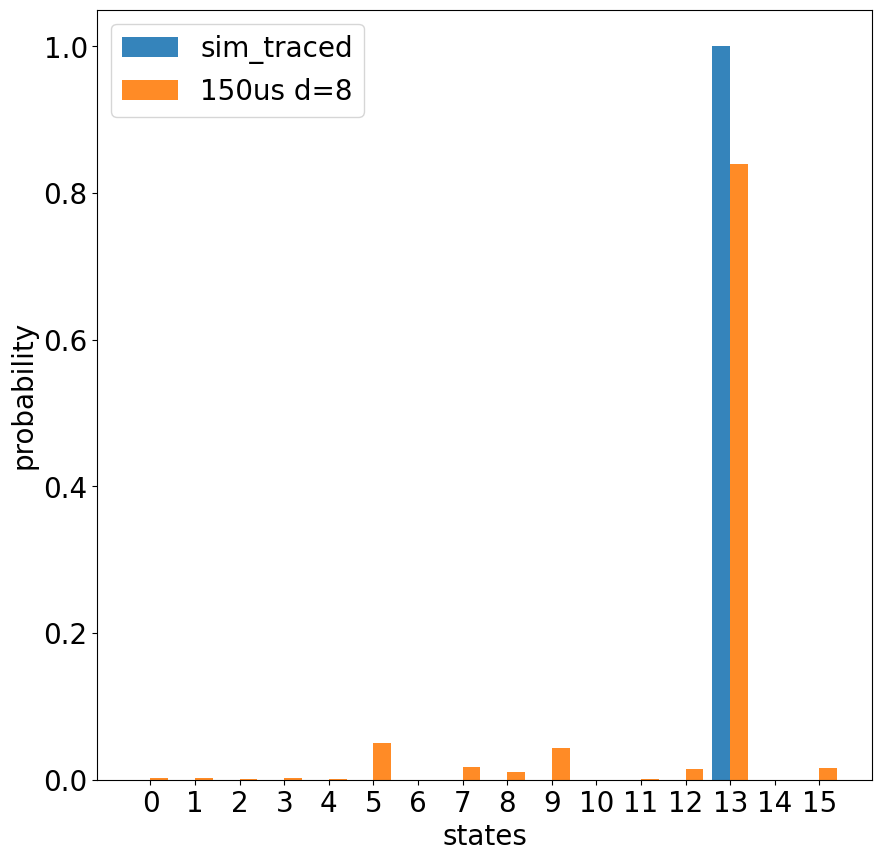

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



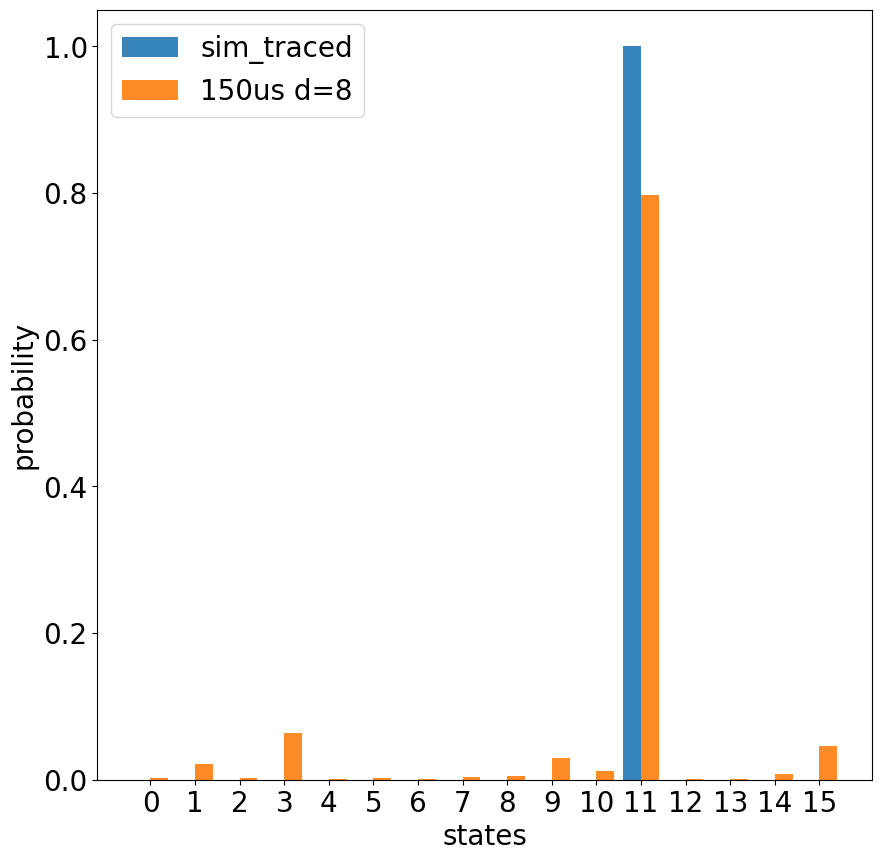

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:FTXA230.2500+:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



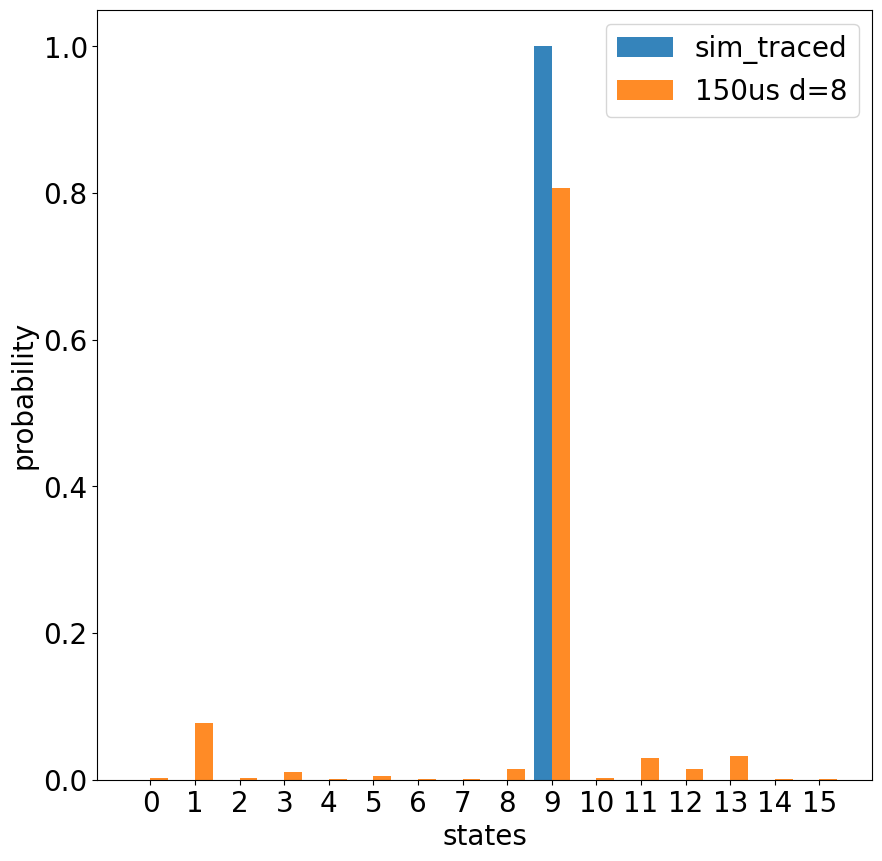

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



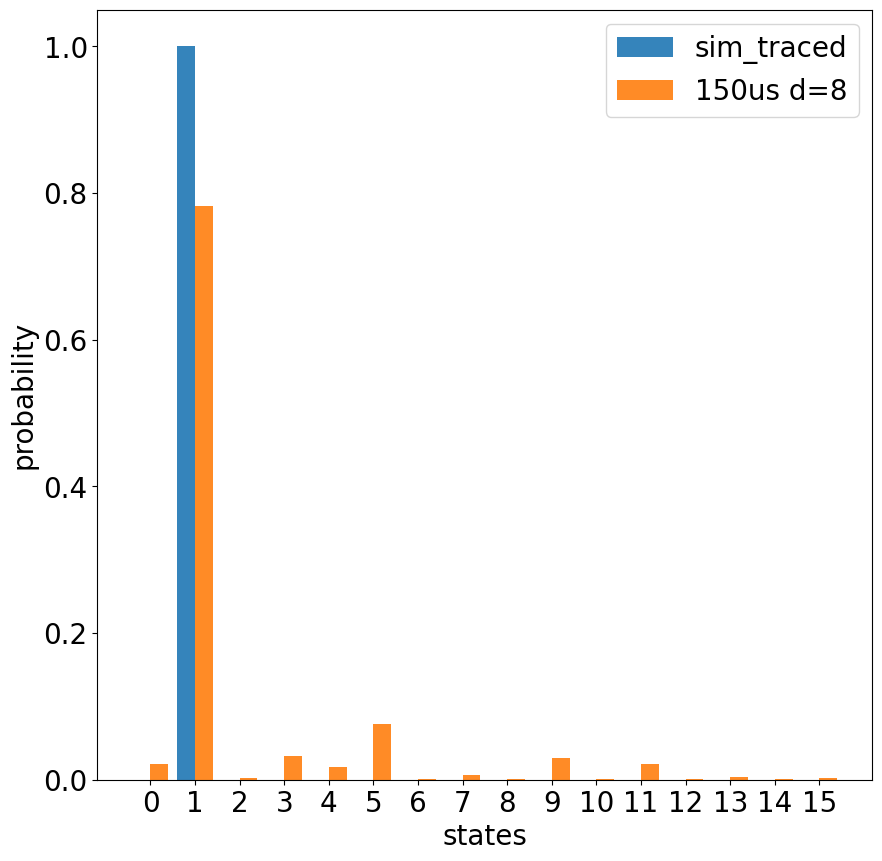

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



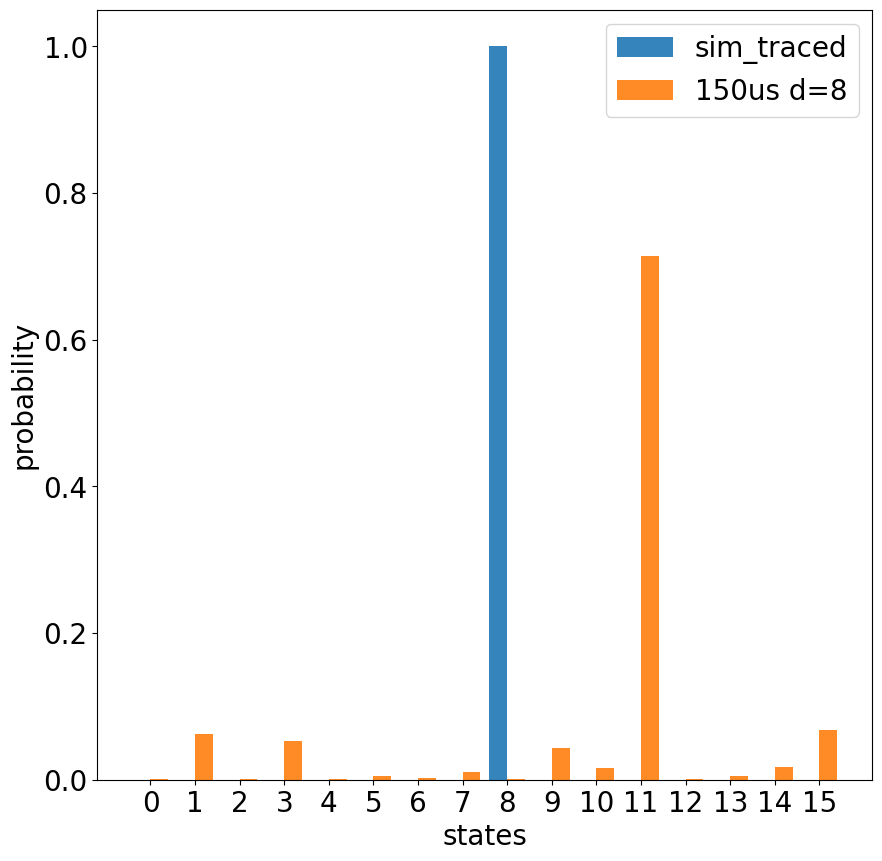

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



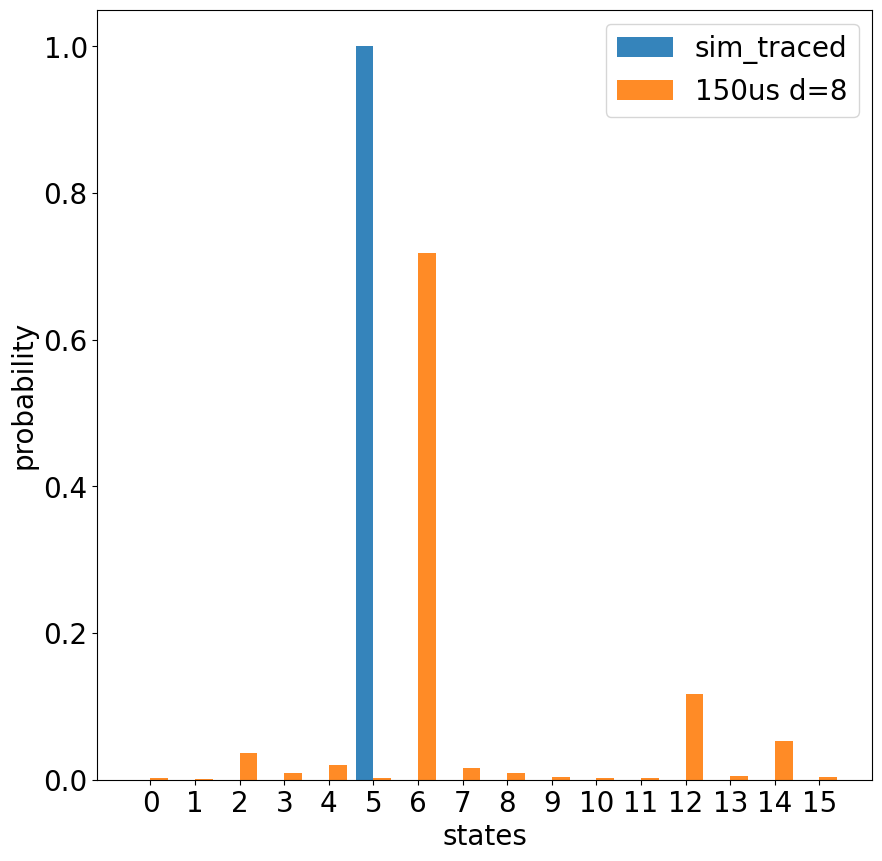

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



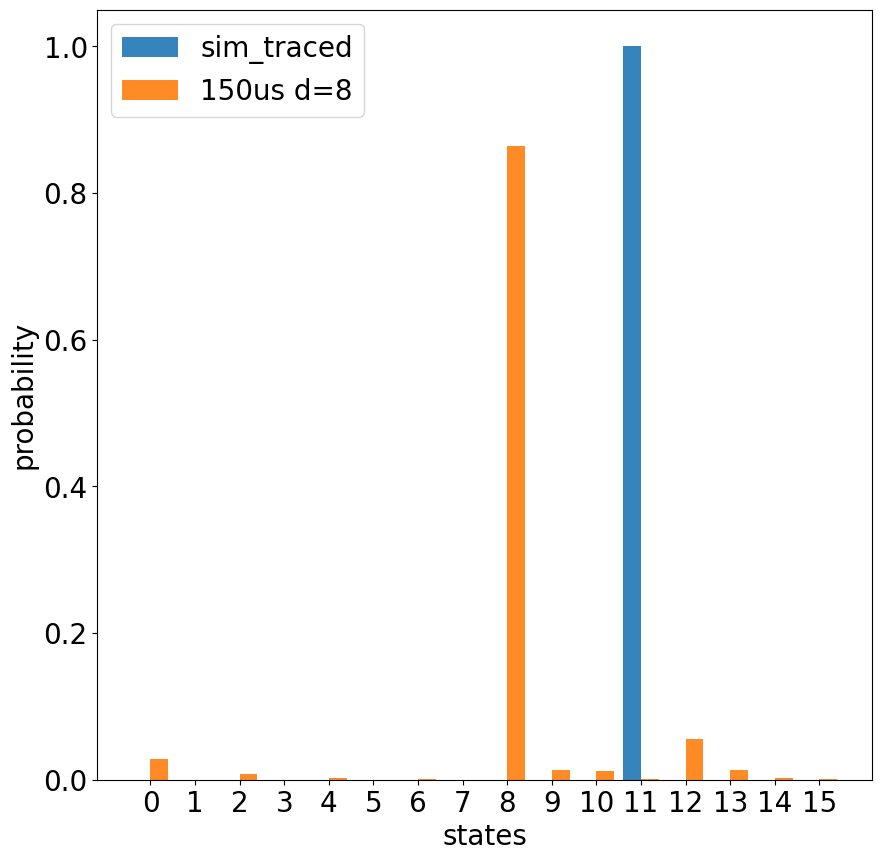

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



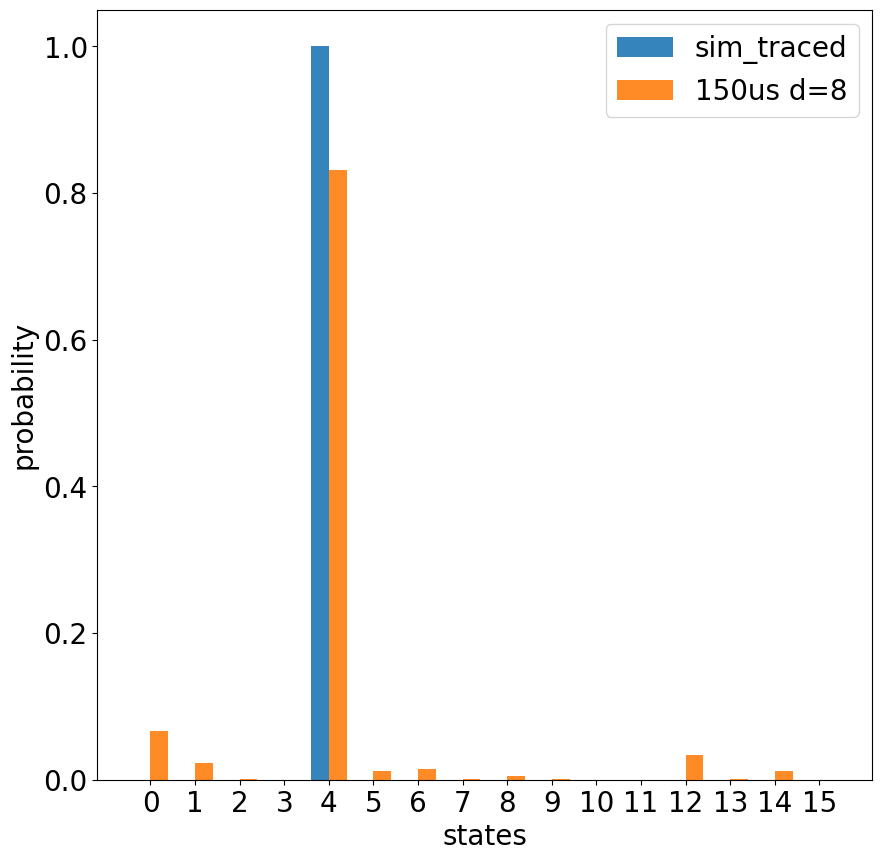

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



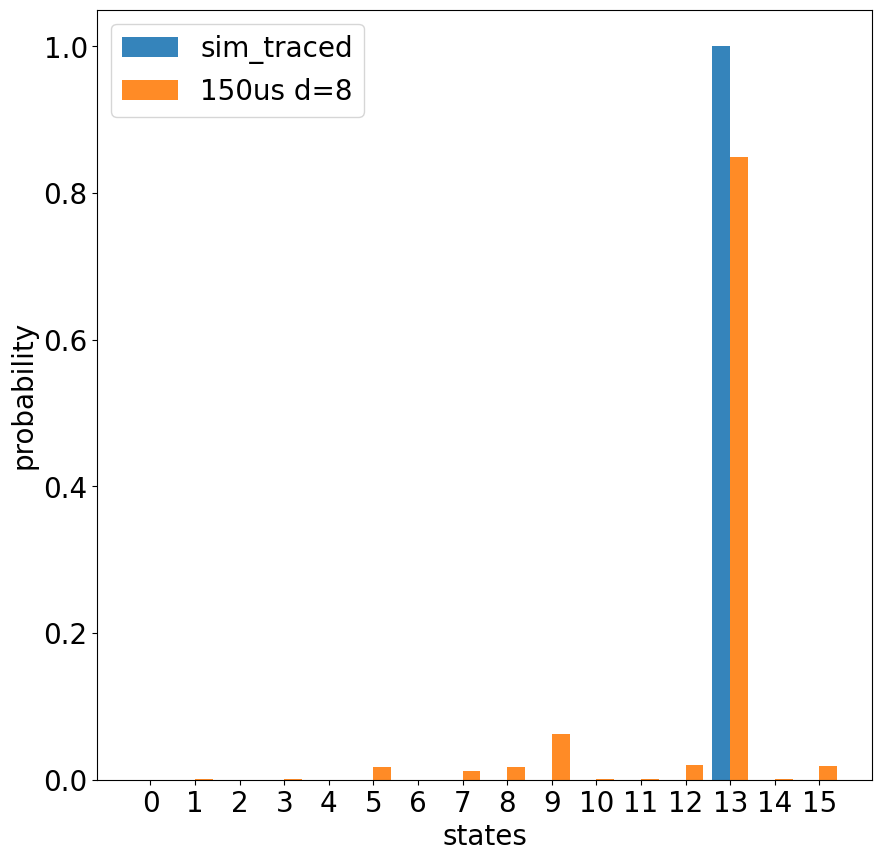

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



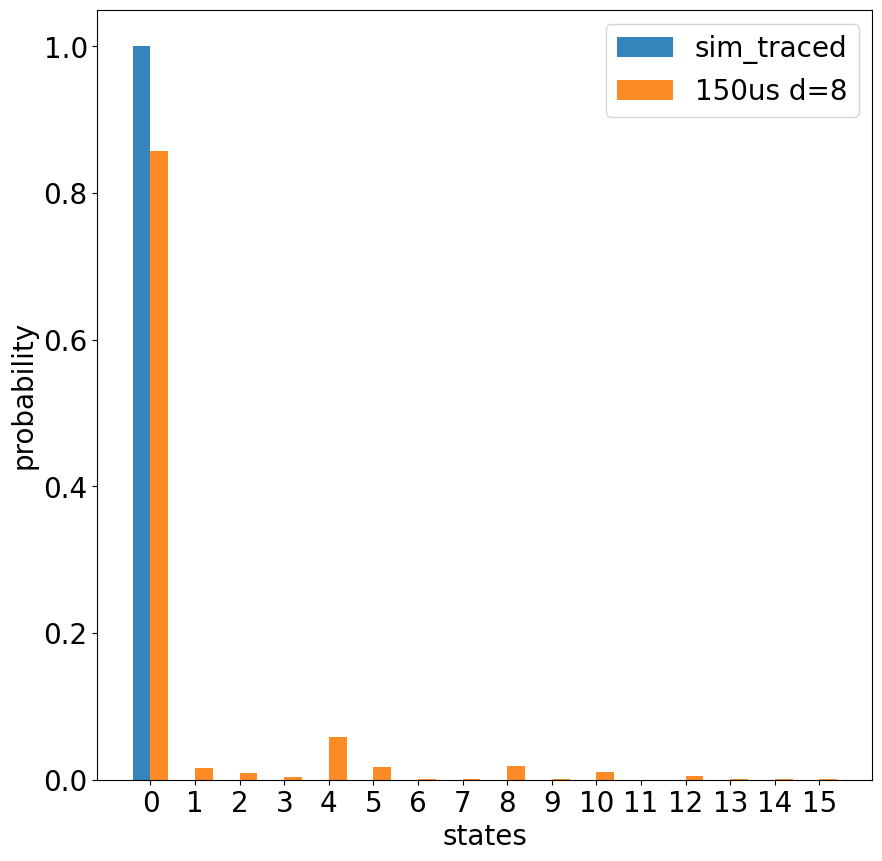

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



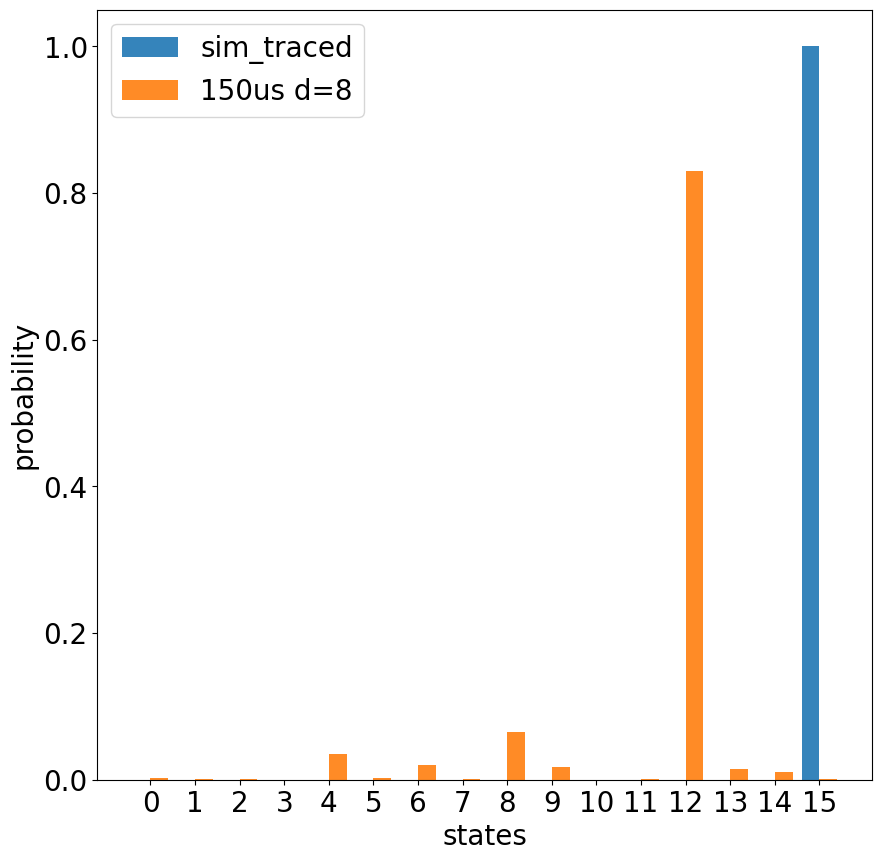

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



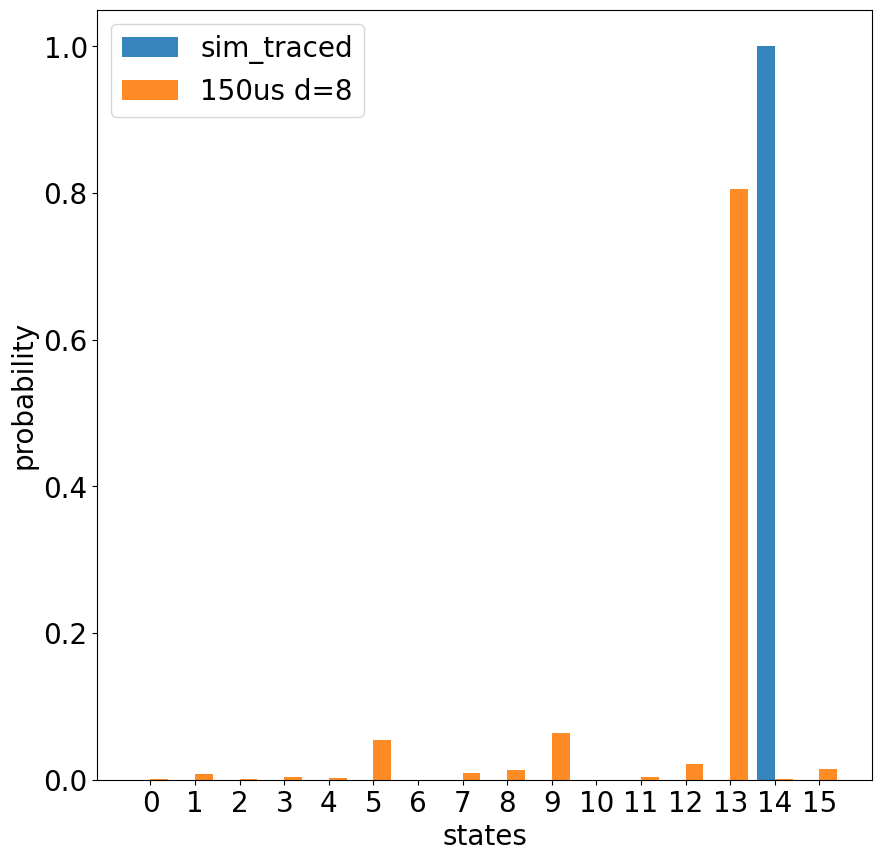

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



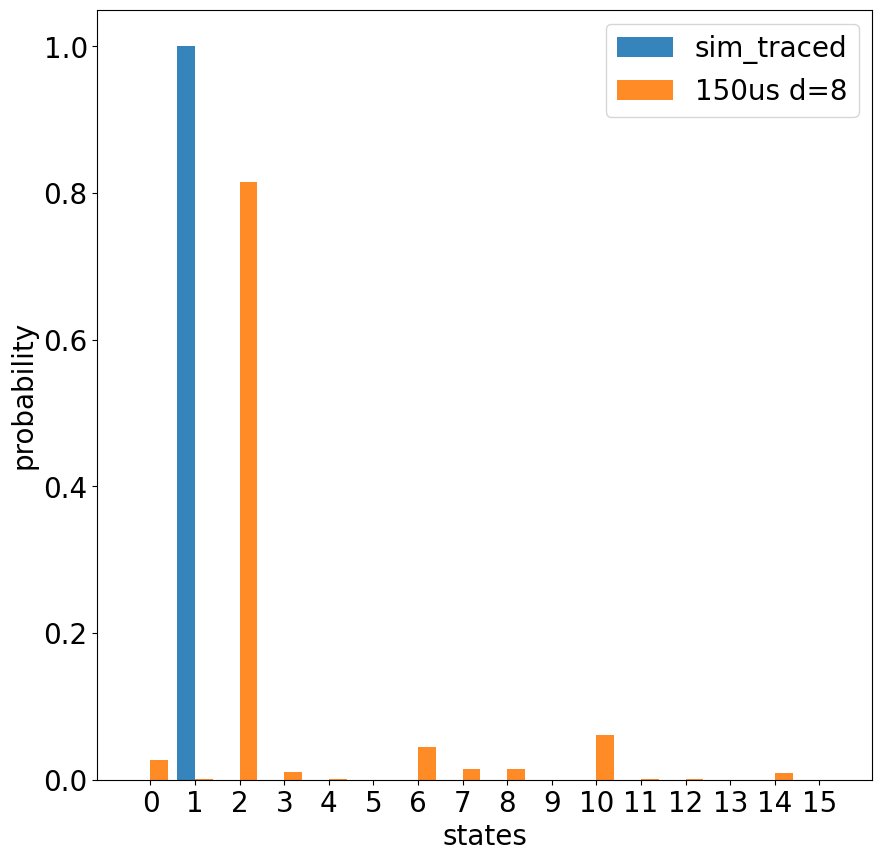

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



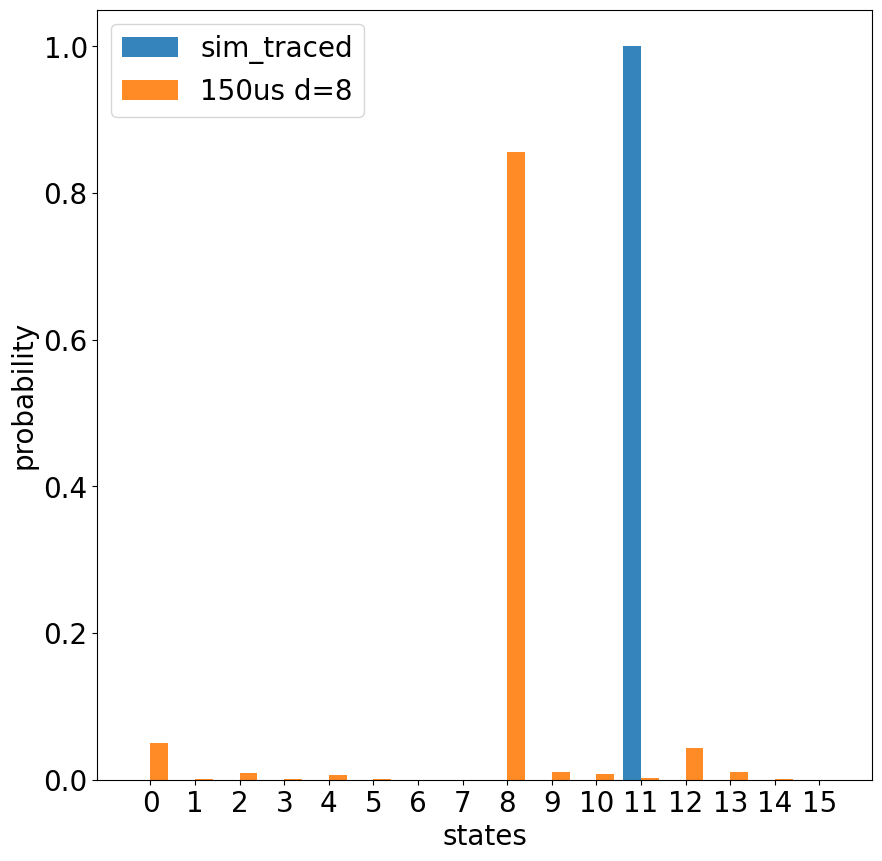

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



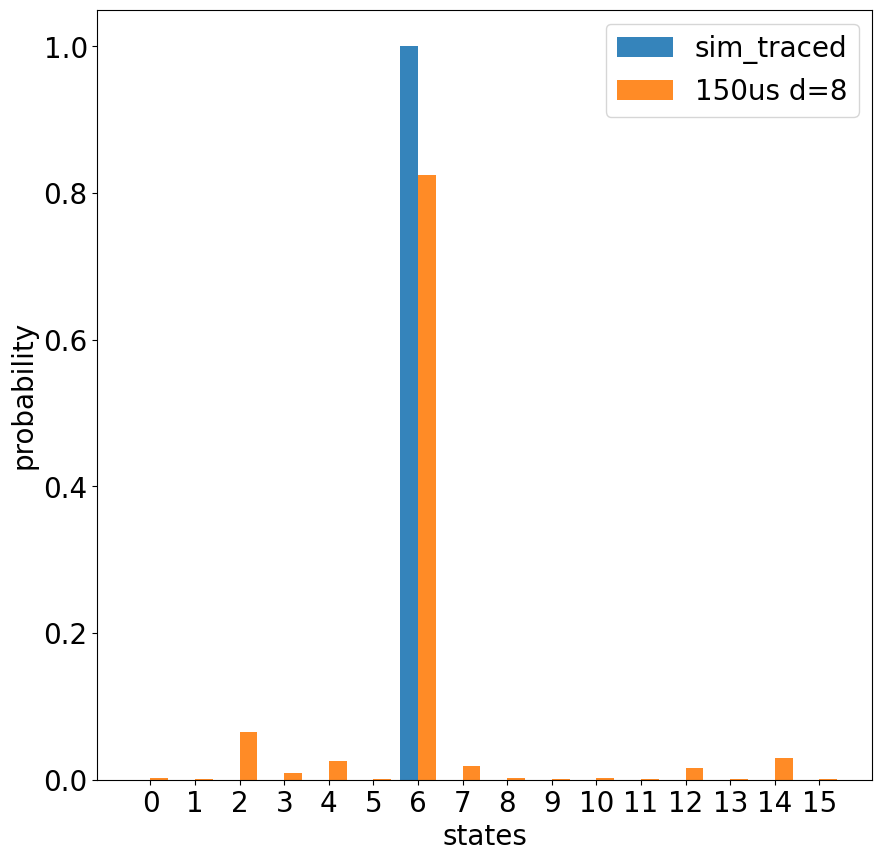

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



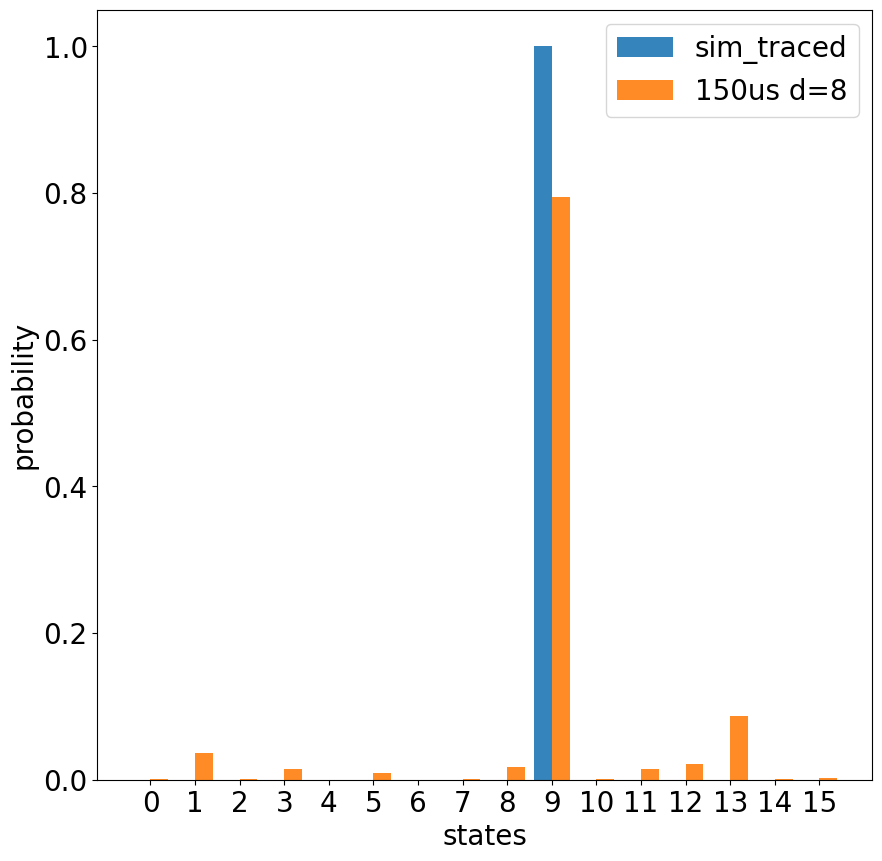

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



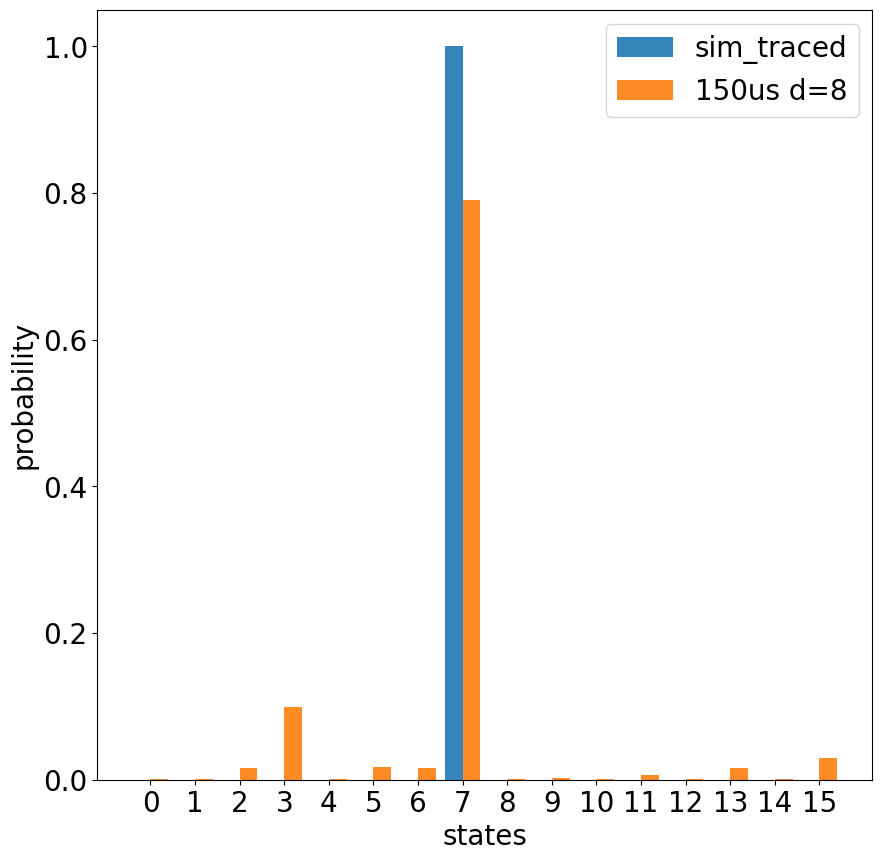

In [76]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","150us d=8"])

In [77]:
# filenames_data=[]
# counts_d16=[]
# counts_d16_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d16_0115.copy()
# print (filenames_data)
# # # print (len(filenames_data))
# paf_data=paf_data_d16_0115
# circuit=c_d16
# for i in range (len(filenames_data)):
#     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d16.append(counts_ibm_mapping_dic)
    
# #     a_s=spam1.Correct_SPAM(a)
# #     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
# #     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
# #     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
# #     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
# #     a_0703.Import(paf_data_d16_0115+filenames_d16_0115[i],keep_file=True)
# #     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
#     Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0115"])

['2024-02-06-201804_Line_001.txt', '2024-02-06-201907_Line_002.txt', '2024-02-06-202012_Line_003.txt', '2024-02-06-202115_Line_004.txt', '2024-02-06-202216_Line_005.txt', '2024-02-06-202400_Line_006.txt', '2024-02-06-202504_Line_007.txt', '2024-02-06-202607_Line_008.txt', '2024-02-06-202710_Line_009.txt', '2024-02-06-202813_Line_010.txt', '2024-02-06-202956_Line_011.txt', '2024-02-06-203057_Line_012.txt', '2024-02-06-203200_Line_013.txt', '2024-02-06-203301_Line_014.txt', '2024-02-06-203402_Line_015.txt', '2024-02-06-203546_Line_016.txt', '2024-02-06-203650_Line_017.txt', '2024-02-06-203753_Line_018.txt', '2024-02-06-203857_Line_019.txt', '2024-02-06-203958_Line_020.txt']
2024-02-06-201804_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA2

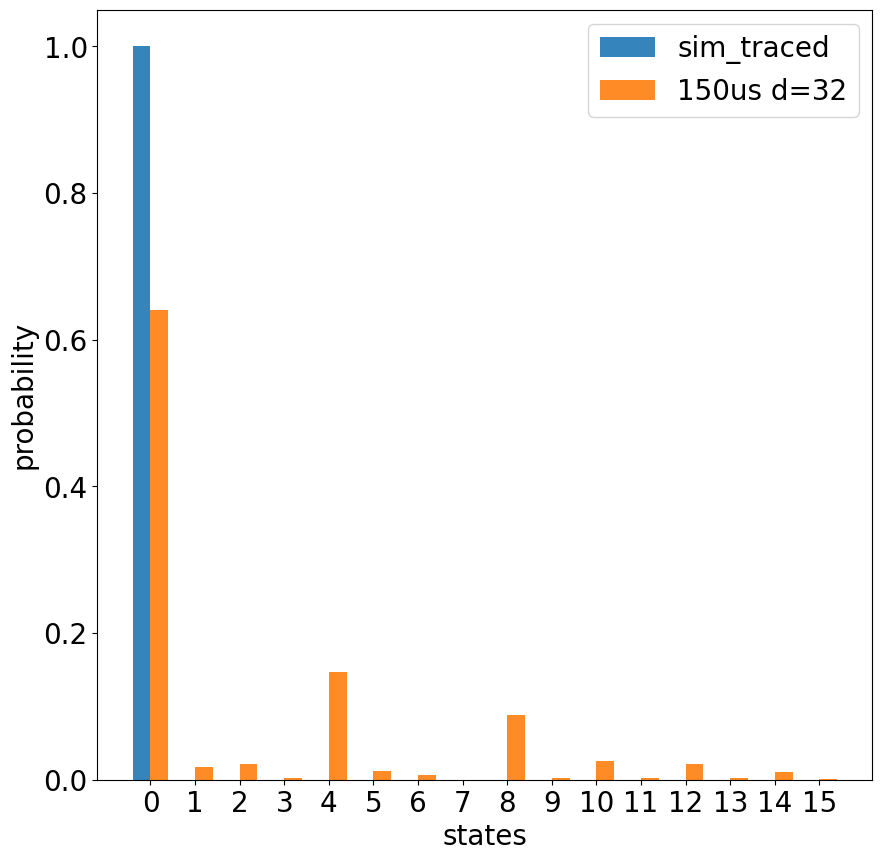

2024-02-06-201907_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-

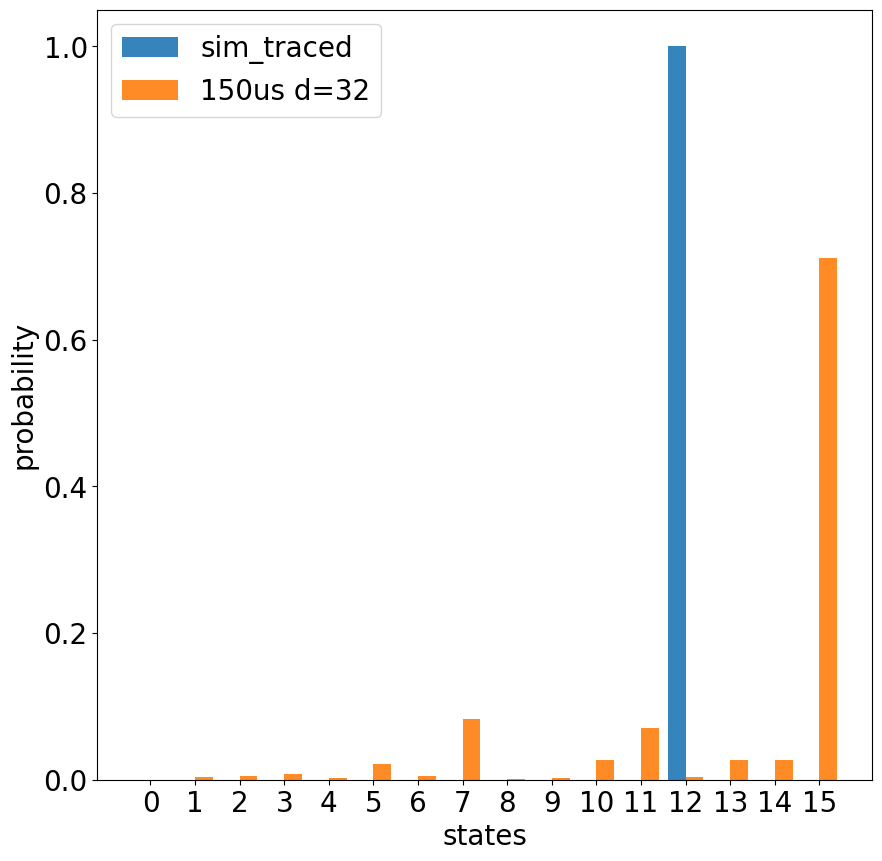

2024-02-06-202012_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:

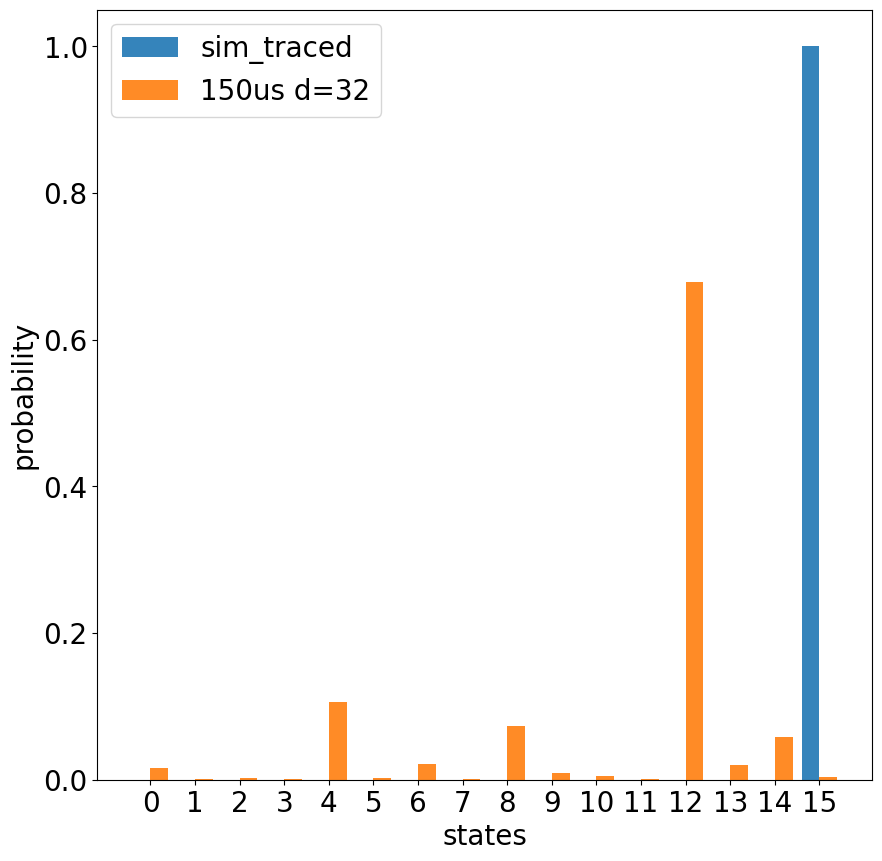

2024-02-06-202115_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:F

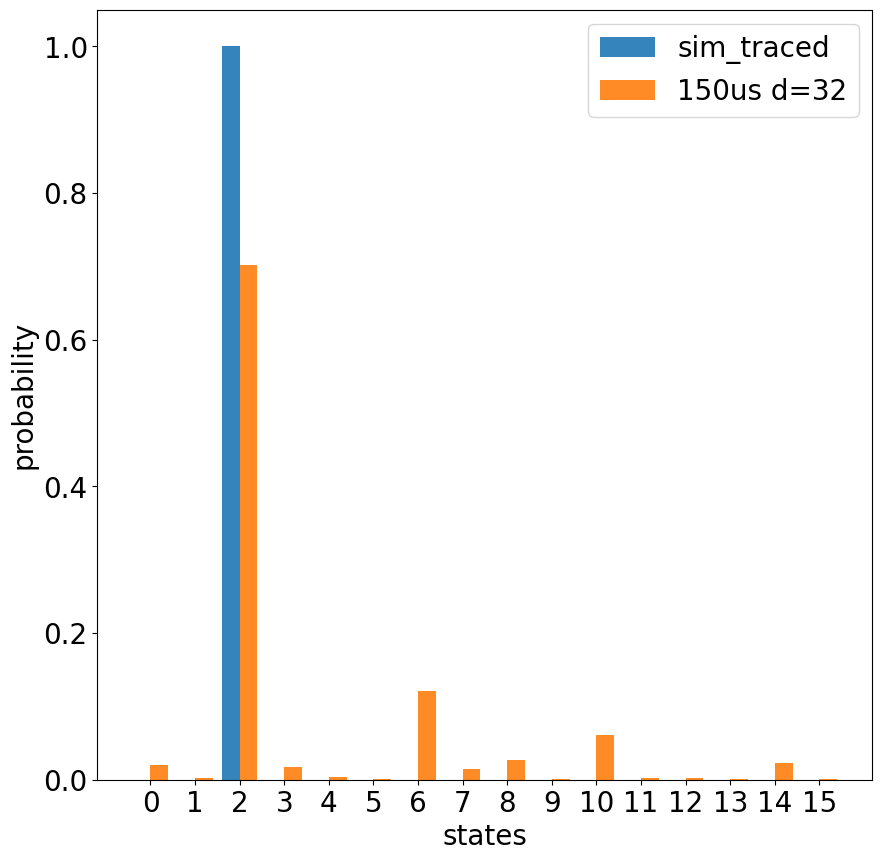

2024-02-06-202216_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52

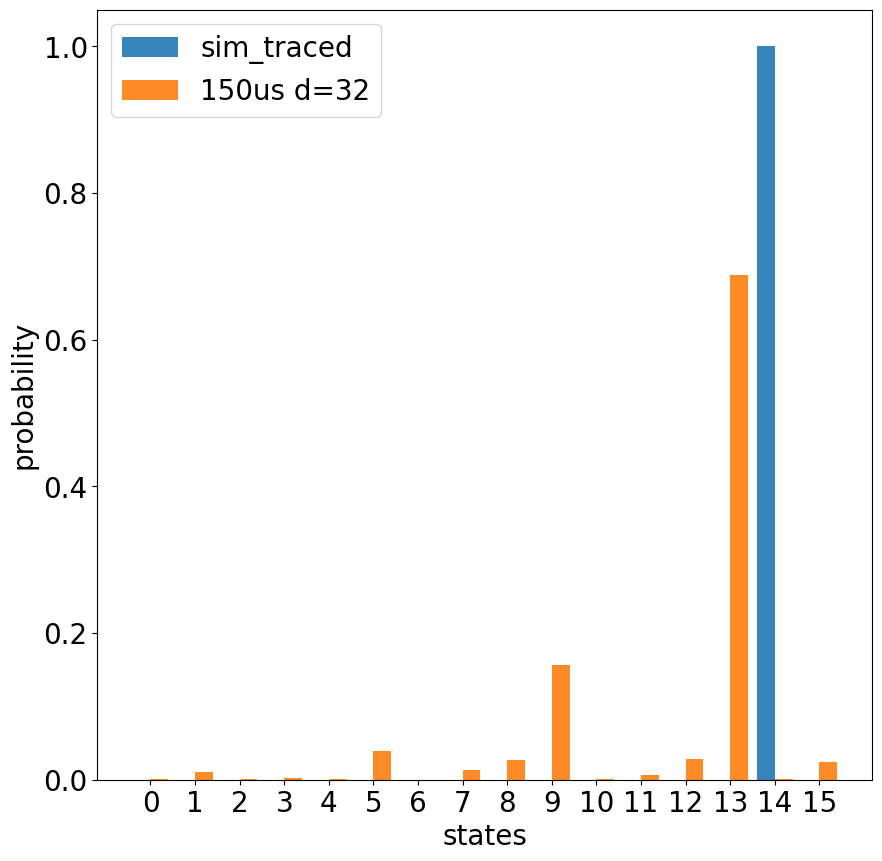

2024-02-06-202400_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+22:FTXA25

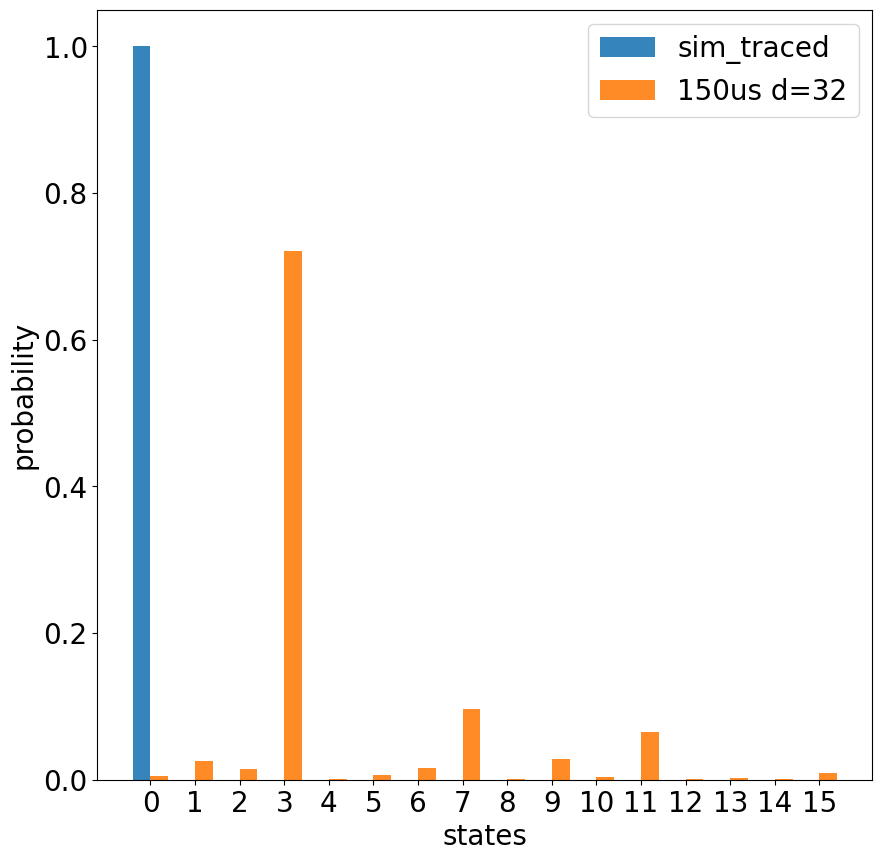

2024-02-06-202504_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-

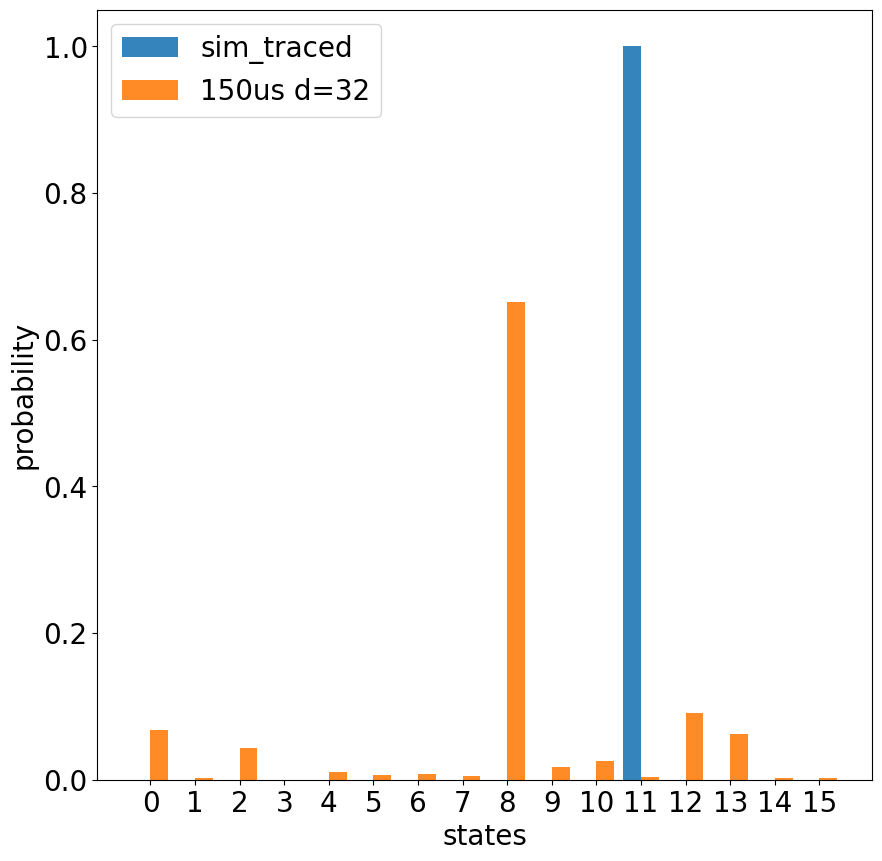

2024-02-06-202607_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+31:RY+22

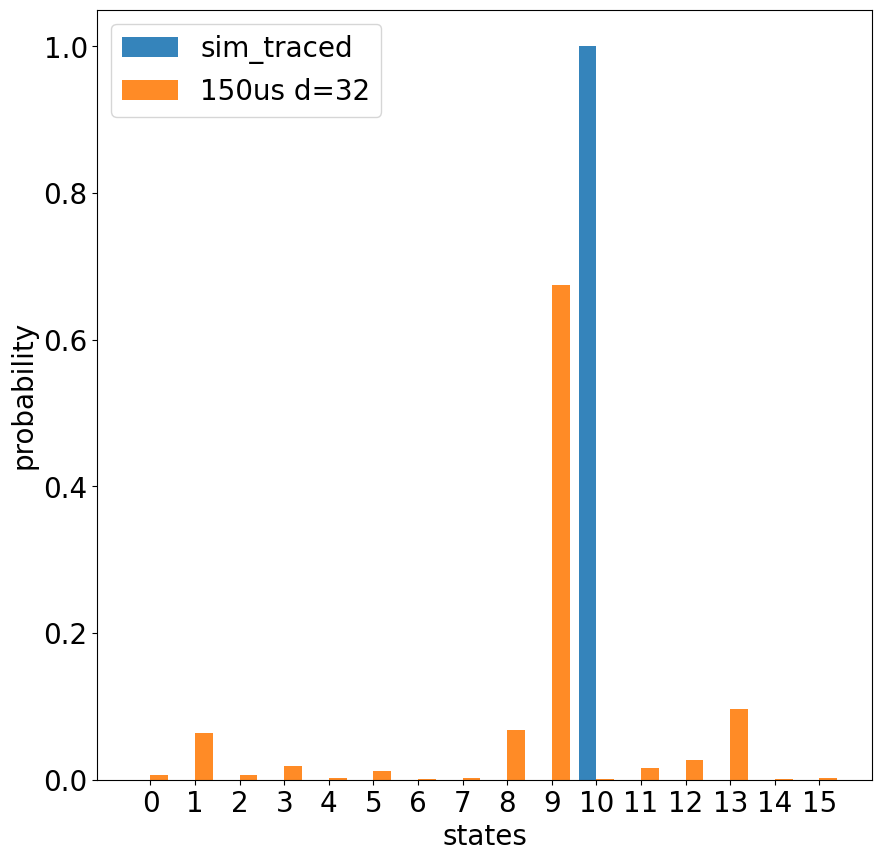

2024-02-06-202710_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FT

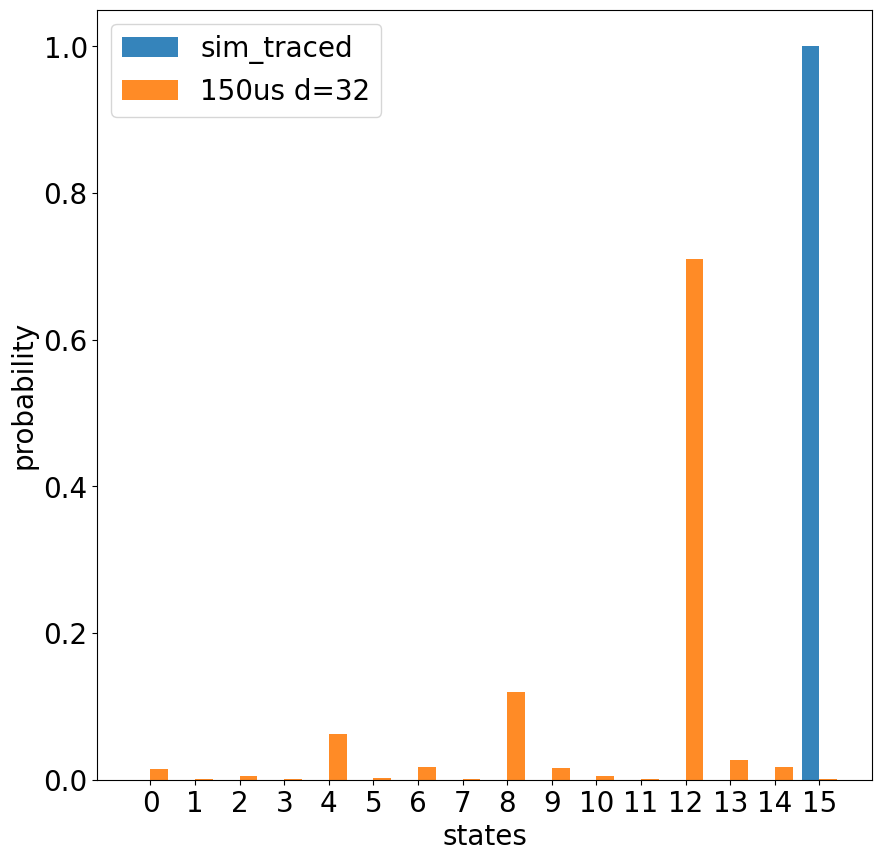

2024-02-06-202813_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ3+1.0000:RY+22

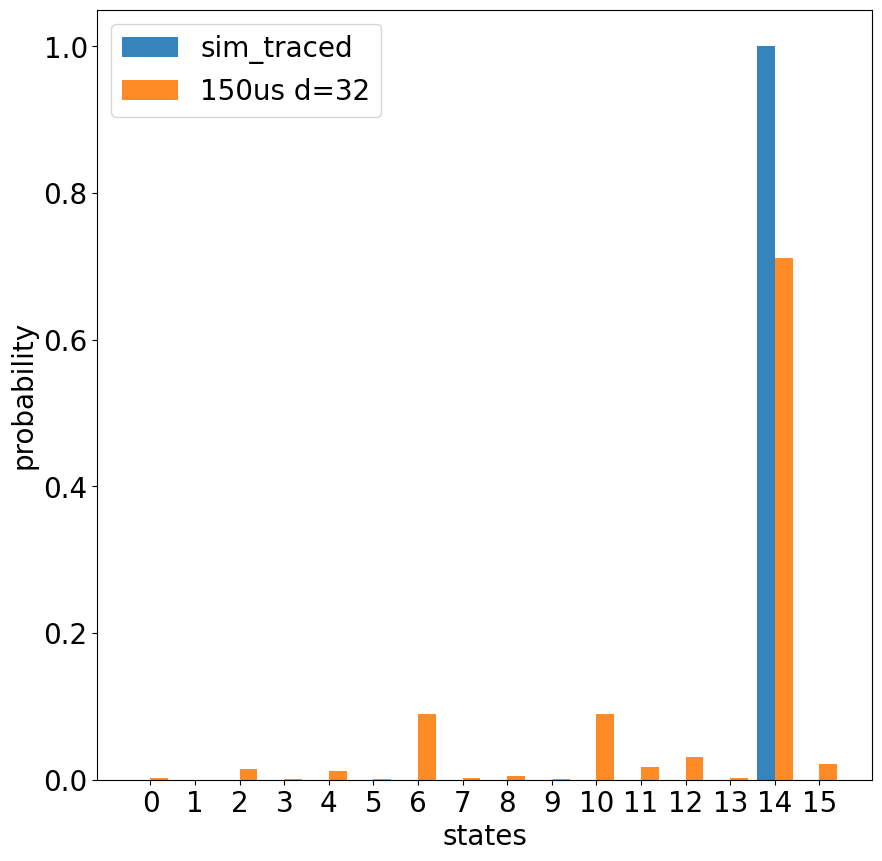

2024-02-06-202956_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2

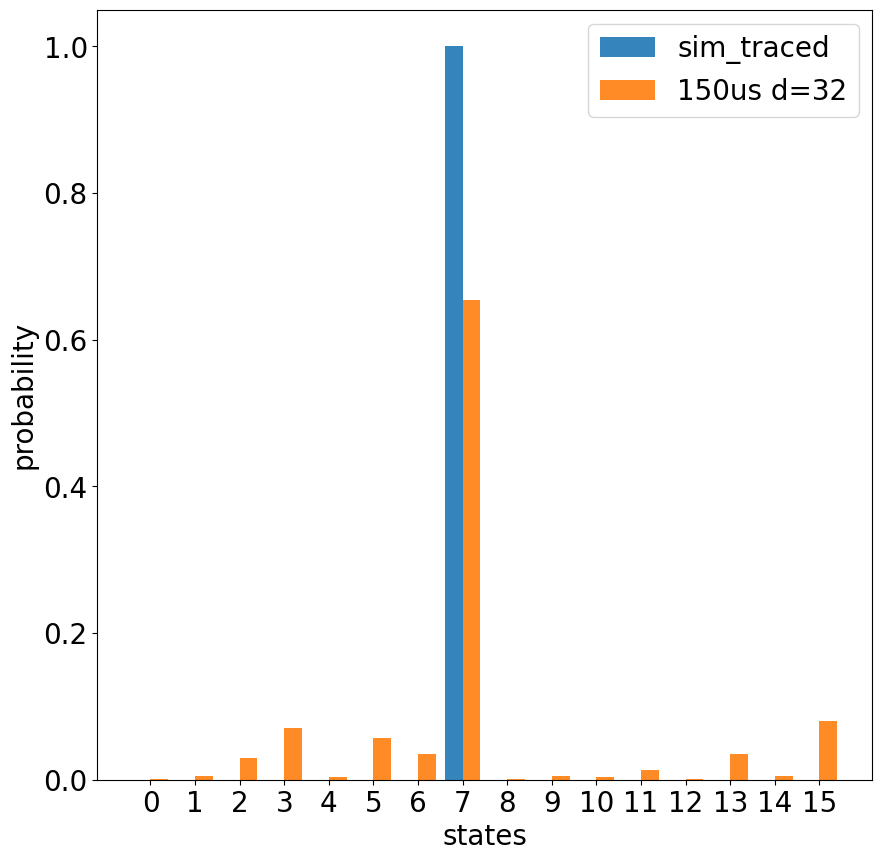

2024-02-06-203057_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-4

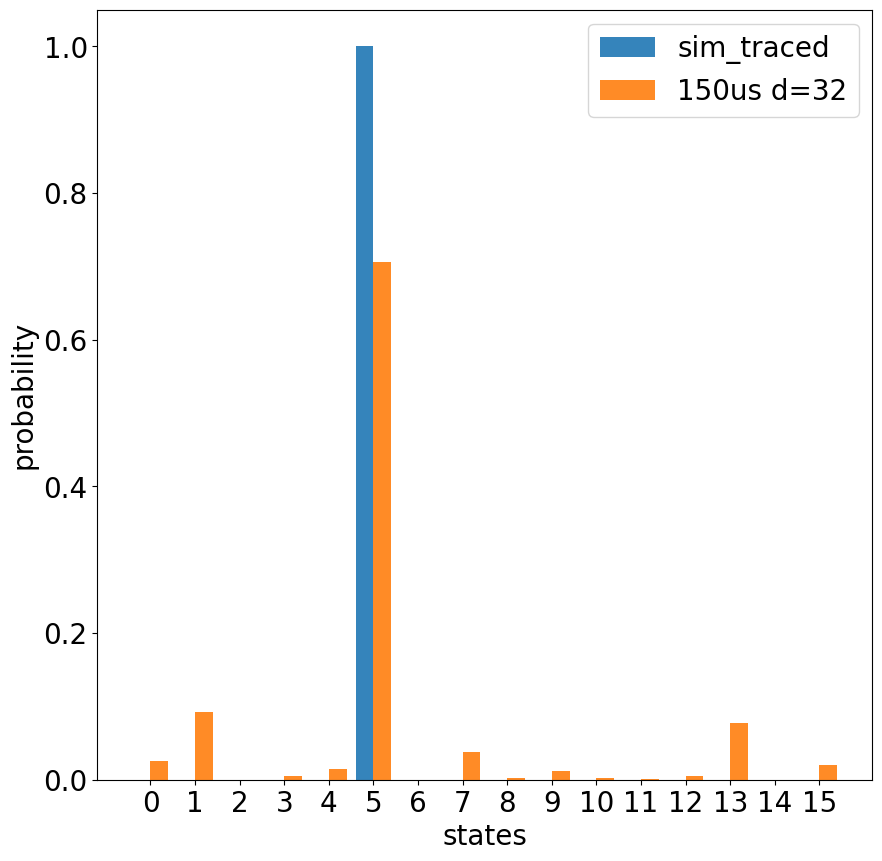

2024-02-06-203200_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX

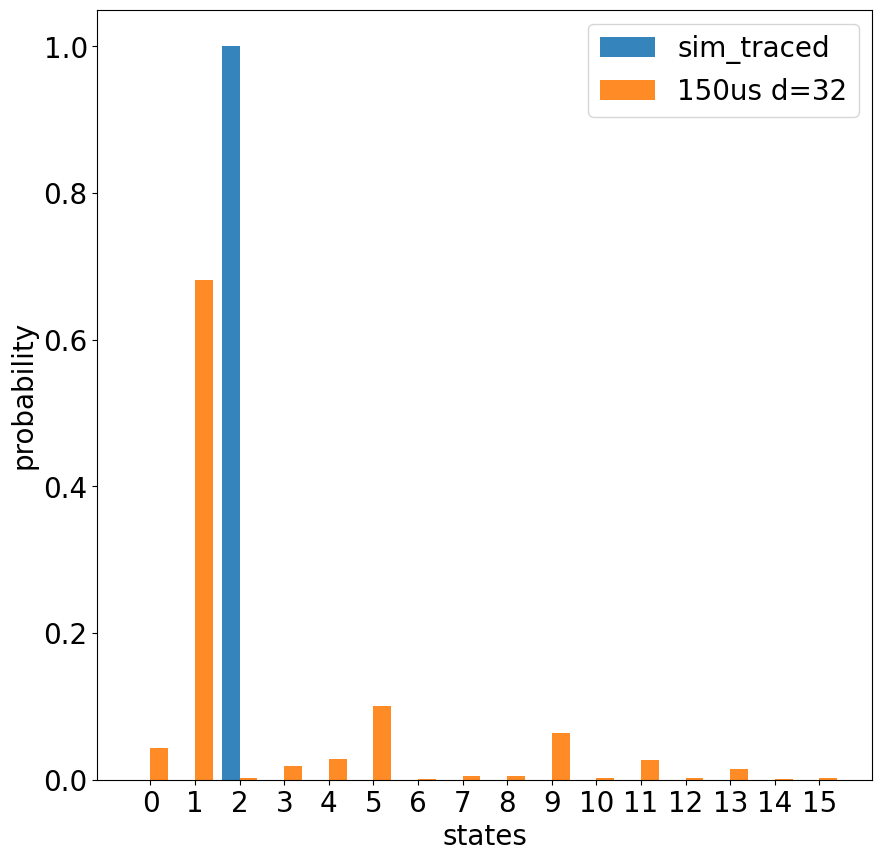

2024-02-06-203301_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY

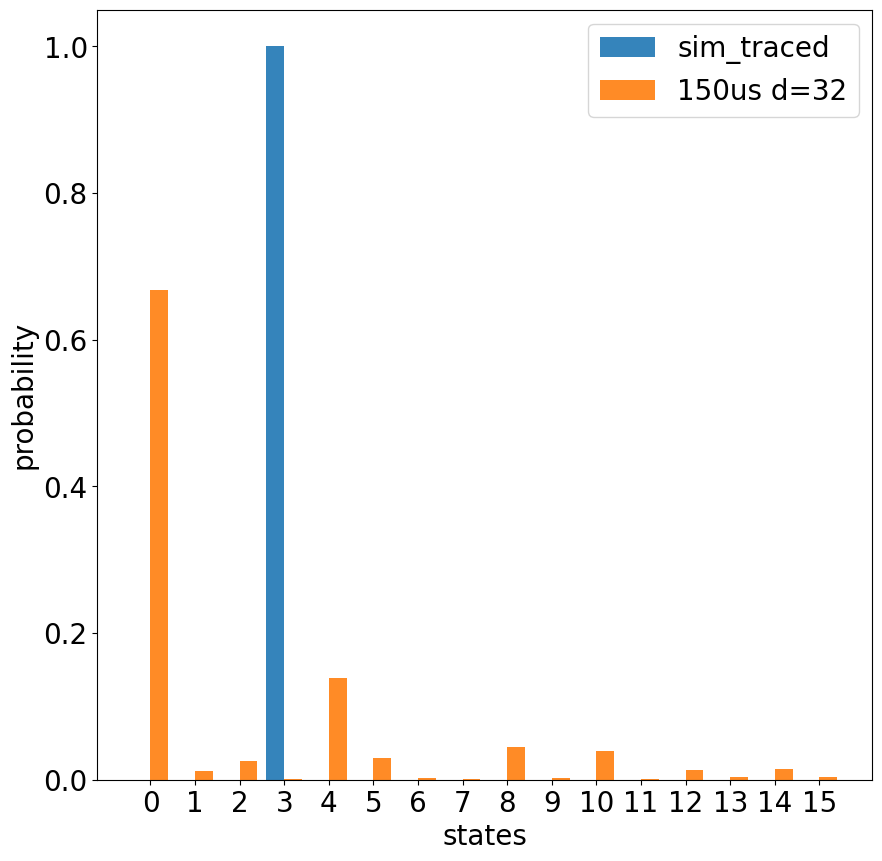

2024-02-06-203402_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:

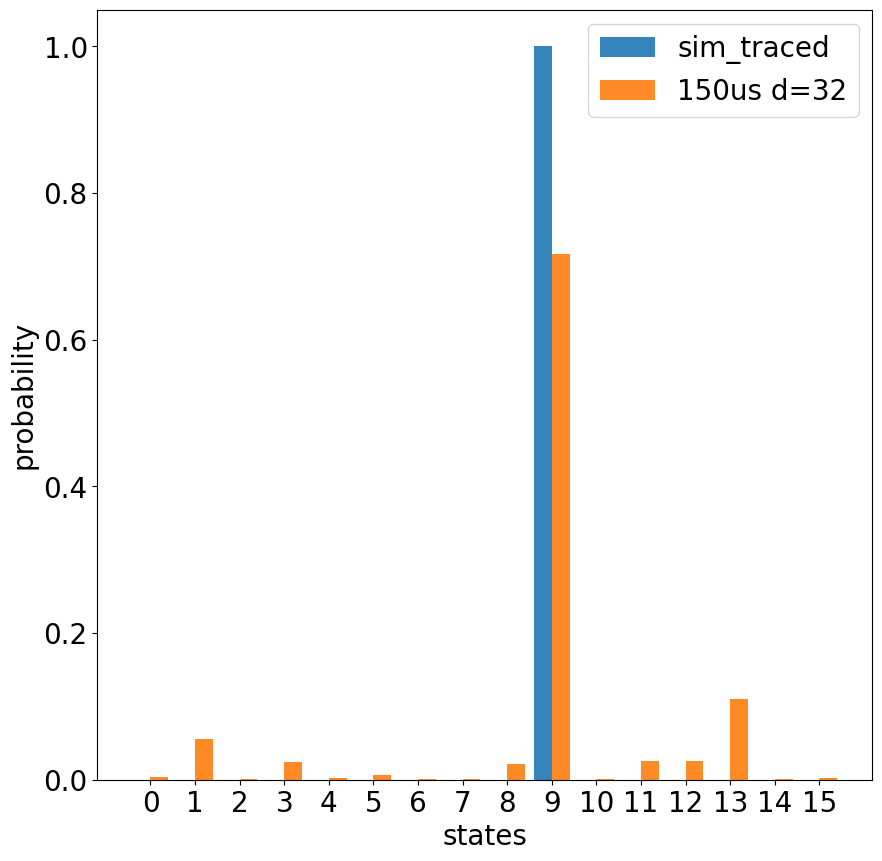

2024-02-06-203546_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA

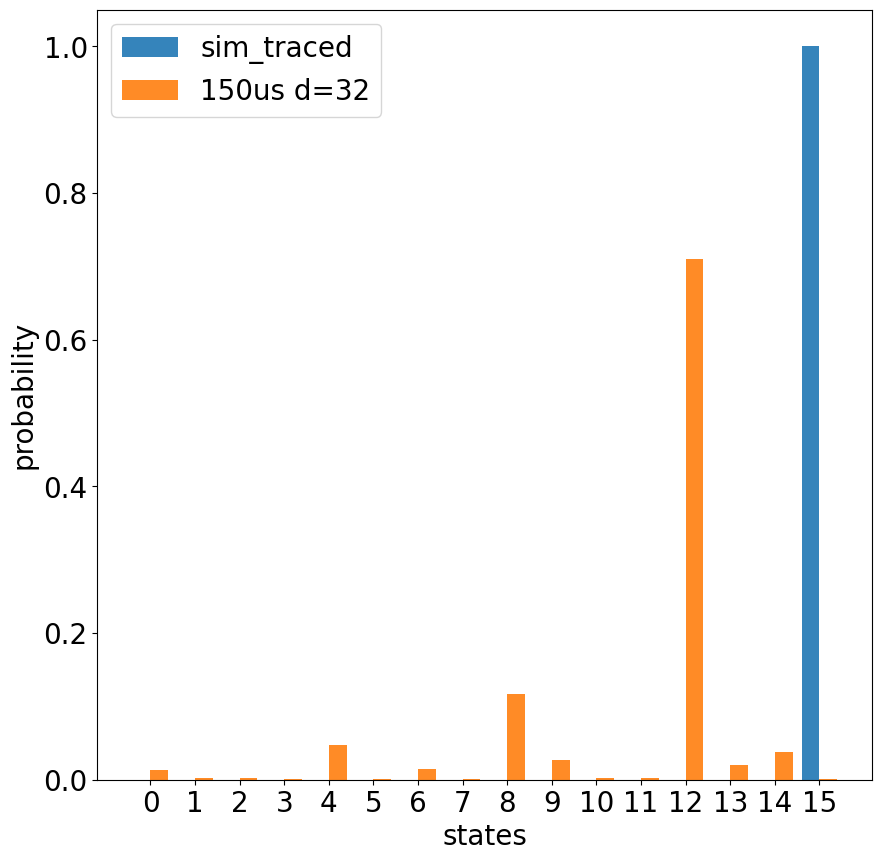

2024-02-06-203650_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2

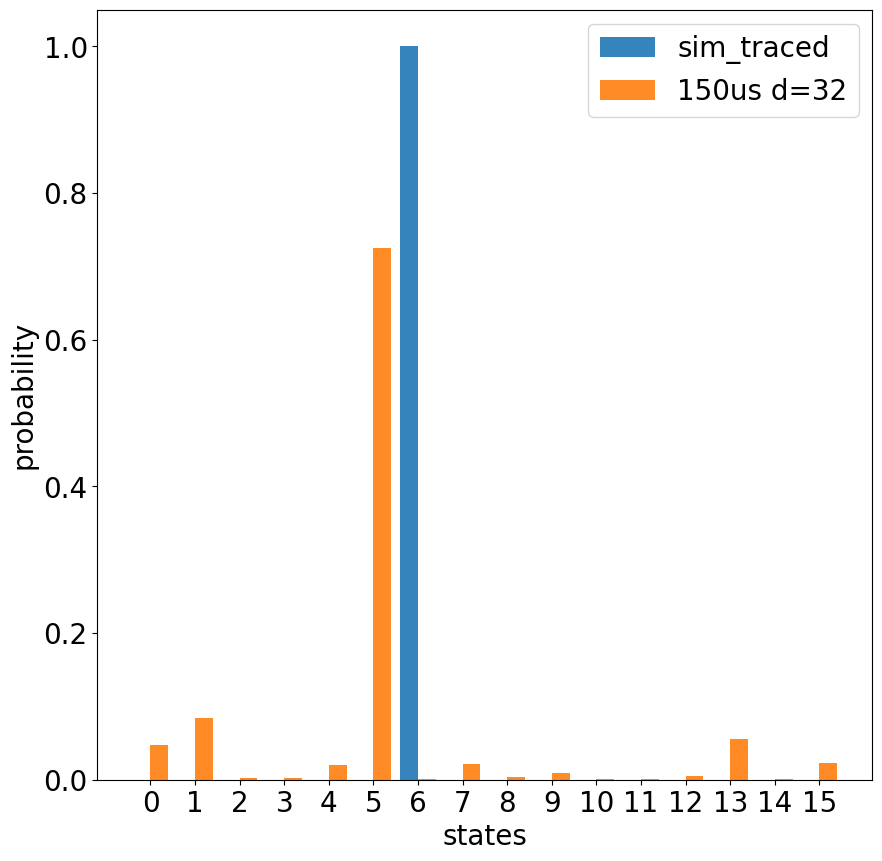

2024-02-06-203753_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-

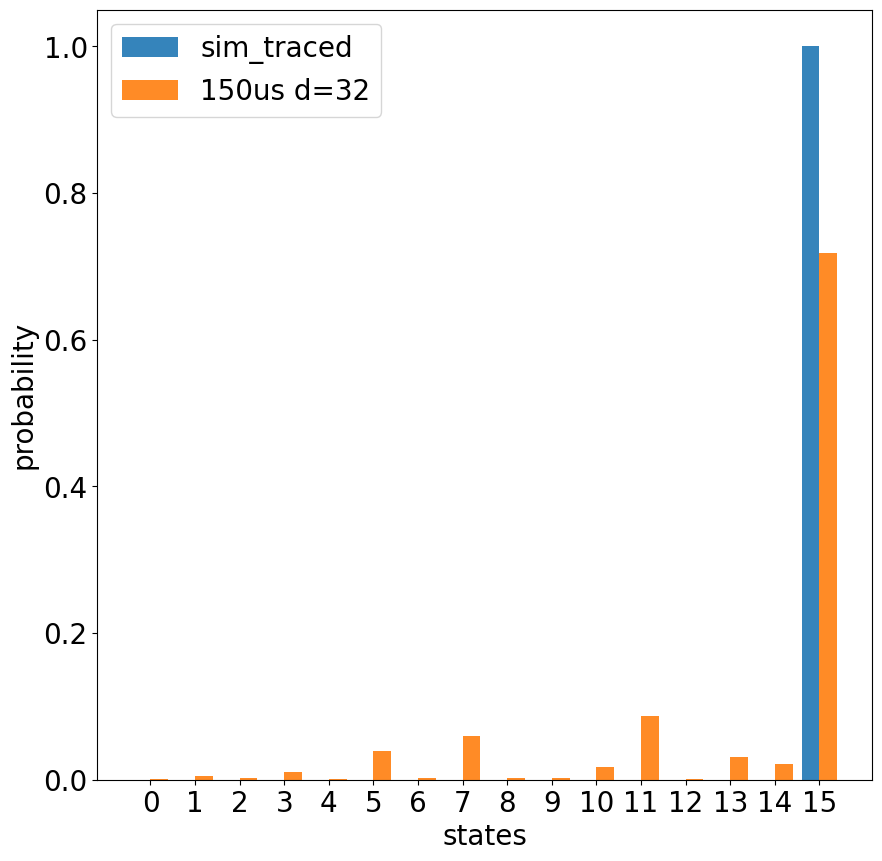

2024-02-06-203857_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:RY+22:FTXA

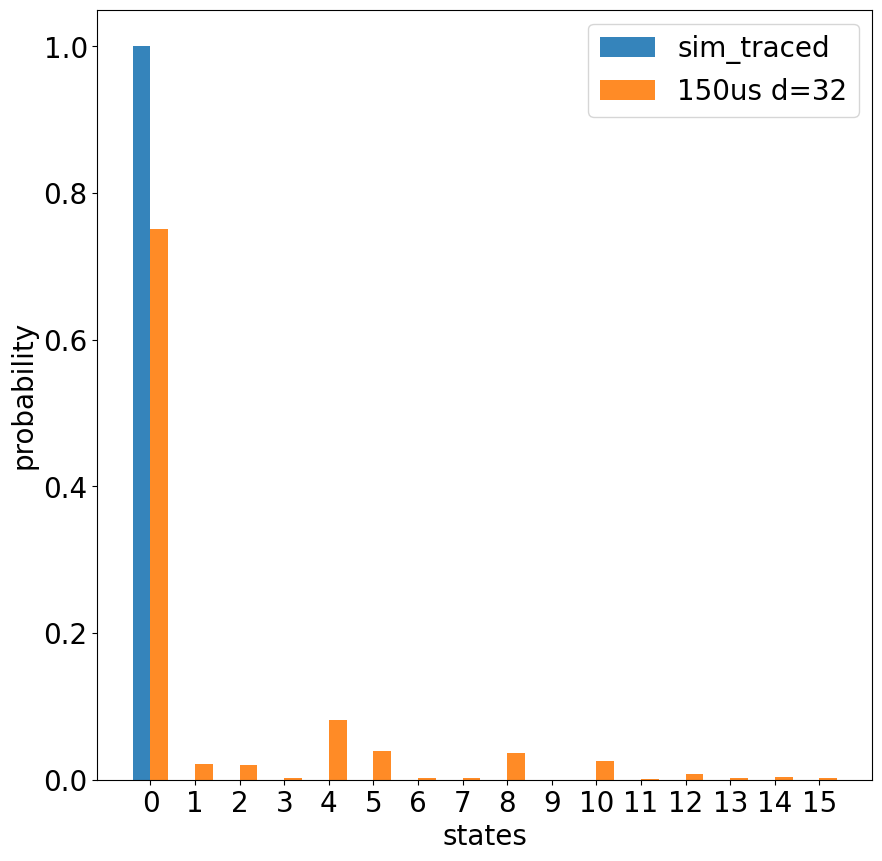

2024-02-06-203958_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



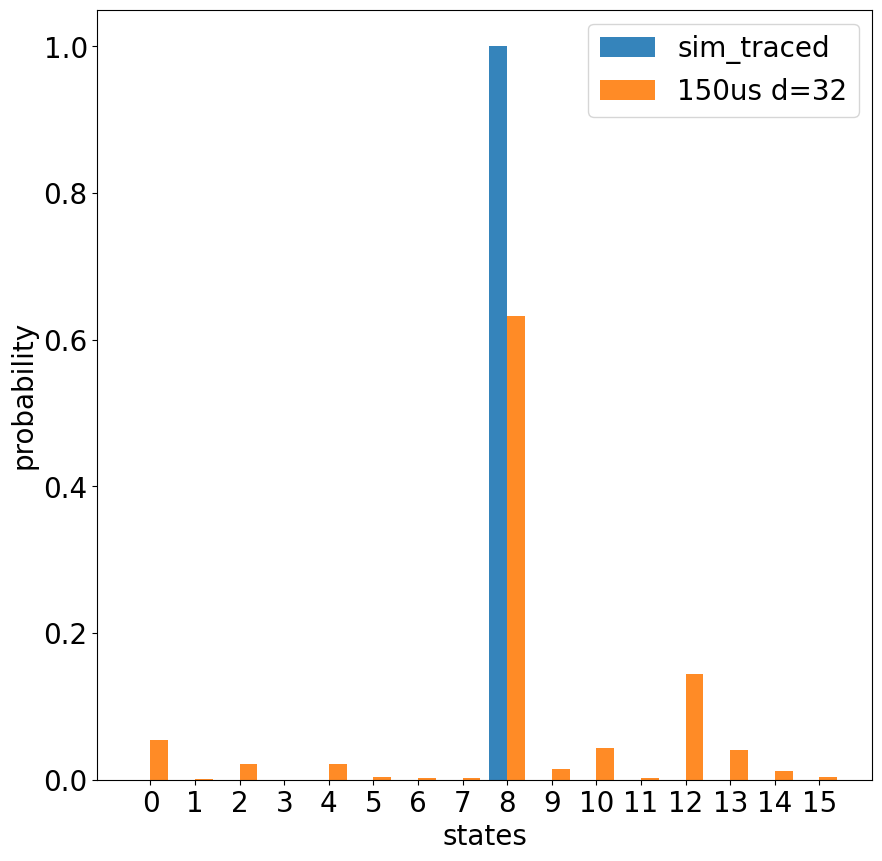

In [78]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","150us d=32"])

In [79]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [80]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/02062024 EAB_FT_01+10_23541/c11f6f1a-7a1a-4af1-b587-cb078b63752eXX23541_FT_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [81]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    print (eab_load_cpy[i]["counts"])
    # print (counts_d2_sim[i])

    # print (counts_d2[i].copy())
    # print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
# for i in range (C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==2
#     eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

{'0000': 0, '1000': 2000, '0100': 0, '1100': 0, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 2000, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 2000, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 2000}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, 

In [82]:
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==4
#     eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()


In [83]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()


In [84]:
# print (eab_load_cpy)

In [85]:
# for i in range (3*C,4*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==16
#     eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [86]:
filename = str(uuid.uuid4())
filename+="XX23541_150us_wait_FT_01+10_02062024_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/scan wait time test/150us/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


In [87]:
print ("done")

done


Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)